In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.patches import Rectangle
import sys
sys.path.append('../annotationmodeling')
from agreement import InterAnnotatorAgreement
from stutter.utils import LabelMap


### Prepare data

In [2]:
class Vector(object):

    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.centroid = (start + end) / 2
        
    def __sub__(self, other):
        return Vector(self.end, other.start)
    
    def __gt__(self, other):
        if isinstance(other, Vector):
            return self.start > other.start
        return NotImplemented
    
    def __lt__(self, other):
        if isinstance(other, Vector):
            return self.start < other.start
        return NotImplemented
        
    def intersects(self, other):
        # check if two vectors intersect
        return self.start <= other.end and other.start <= self.end
        
    def __len__(self):
        return self.end - self.start
    
    def __str__(self):
        return f'({self.start}, {self.end})'

#  define Distance functions
def iou(a:Vector, b: Vector):
    intersection = max(0, min(a.end, b.end) - max(a.start, b.start))
    union = len(a) + len(b) - intersection
    return intersection / union

def simple_distance(a, b):
    return abs(a - b)

def precision(a, b):
    true_positive = a==b
    false_positive = a!=b
    return true_positive / (true_positive + false_positive)

def recall(a, b):
    true_positive = a==b
    false_negative = a!=b
    return true_positive / (true_positive + false_negative)

def f1_score(a, b):
    p = precision(a, b)
    r = recall(a, b)
    return 2 * (p * r) / (p + r)

def iou_multiple(vas, vbs):
    return np.mean([iou(va, vb) for va in vas for vb in vbs])

def inv_iou(x, y):
    return 1 - iou(x, y)

def normalized_hamming_distance(label1, label2):
    differences = sum(1 for l1, l2 in zip(label1[1], label2[1]) if l1 != l2)
    hamming_distance = differences / len(label1)
    return hamming_distance

def normalized_ordinal_distance(ordinal1, ordinal2, max_value=3):
    ordinal_distance = abs(ordinal1 - ordinal2) / max_value
    return ordinal_distance

def normalized_ordinal_distance_multiple(ordinal1s, ordinal2s, max_value):
    return np.mean([normalized_ordinal_distance(o1, o2) for o1 in ordinal1s for o2 in ordinal2s])

def normalized_hamming_distance_multiple(labels1, labels2):
    return np.mean([normalized_hamming_distance(l1, l2) for l1 in labels1 for l2 in labels2])

def score(row1, row2, weights=(0.33, 0.33, 0.34)):
    # iou_score = iou(row1[0], row2[0])
    hamming_score = normalized_hamming_distance(row1[1], row2[1])
    ordinal_score = normalized_ordinal_distance(row1[2][0], row2[2][0], 3)
    return sum([hamming_score * weights[1], ordinal_score * weights[2]])

def score_multiple(row1, row2):
    return np.mean([score(r1, r2) for r1 in row1 for r2 in row2])


In [3]:
df = pd.read_csv('../datasets/fluencybank/our_annotations/reading/csv/total_label.csv')
df['timevr'] = df.apply(lambda row: Vector(row['start'], row['end']), axis=1)
df['annotations'] = df.apply(lambda row: [Vector(row['start'], row['end']), row['label']], axis=1)
df_ann = df[df['annotator'].isin(['A1', 'A2', 'A3'])]
df_gold = df[df['annotator'] == 'Gold']
df_ann.head()

,media_file,annotator,start,end,label,split,FP,SR,ISR,MUR,P,B,NV,V,FG,HM,ME,T,timevr,annotations
0,60m,A2,5800,6560,_;FG;1,train,0,0,0,0,0,0,0,0,1,0,0,1,"(5800, 6560)","[(5800, 6560), _;FG;1]"
1,60m,A2,9830,10380,_;HM;1,train,0,0,0,0,0,0,0,0,0,1,0,1,"(9830, 10380)","[(9830, 10380), _;HM;1]"
2,60m,A2,11100,11630,_;FG+HM;1,train,0,0,0,0,0,0,0,0,1,1,0,1,"(11100, 11630)","[(11100, 11630), _;FG+HM;1]"
3,60m,A2,17120,17460,_;FG+HM;1,train,0,0,0,0,0,0,0,0,1,1,0,1,"(17120, 17460)","[(17120, 17460), _;FG+HM;1]"
4,60m,A2,29220,31020,MUR;0;1,train,0,0,0,1,0,0,0,0,0,0,0,1,"(29220, 31020)","[(29220, 31020), MUR;0;1]"


In [4]:
#  Unionize the vector ranges in to similar groups

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import euclidean_distances
from collections import defaultdict
import copy

def non_overlapping_distance(a, b):
    # Assuming a and b are tuples or lists of (start, end)
    start_a, end_a = a.start, a.end
    start_b, end_b = b.start, b.end
    if end_a < start_b or end_b < start_a:
        return 2
    else:
        return 1 - iou(a, b)  # Use IoU-based distance for overlapping intervals

def unionize_vectorrange_sequence(vectorranges):
    min_s = min([vr.start for vr in vectorranges])
    max_e = max([vr.end for vr in vectorranges])
    return Vector(min_s, max_e)

def fragment_by_overlaps(annodf, uid_colname, item_colname, label_colname, decomp_fn, dist_fn=None, gold_df=None):
    resultdfs = []
    for item_id in annodf[item_colname].unique():
        idf = annodf[annodf[item_colname] == item_id]
        vectorranges = [vas[0] for vas in idf[label_colname]]

        regions = decomp_fn(vectorranges, dist_fn=dist_fn)
        origItemID = []
        newItemID = []
        newItemVR = []
        uid = []
        label = []
        timevr = []
        goldtimevr = []
        goldlabel = []
        for region in regions:
            for i, row in idf.iterrows():
                if region.intersects(row[label_colname][0]):
                    origItemID.append(item_id)
                    newItemID.append(F"{item_id}-{region}")
                    newItemVR.append(region)
                    uid.append(row[uid_colname])
                    label.append(row['label'])
                    timevr.append(row['timevr'])
                    if gold_df is not None:
                        # get the gold label that intersects with the region
                        gold_timevr = [vr[0] for vr in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(vr[0])]
                        gold_timevr = gold_timevr[0] if len(gold_timevr) > 0 else None
                        goldtimevr.append(gold_timevr)

                        gold_label = [lbl[1] for lbl in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(lbl[0])]
                        gold_label = gold_label[0] if len(gold_label) > 0 else None
                        goldlabel.append(gold_label)
                    else:
                        goldtimevr.append(None)
        resultdfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "newItemVR":newItemVR, uid_colname:uid, label_colname:label, "timevr":timevr, "goldTimeVR":goldtimevr, "gold":goldlabel}))
    return pd.concat(resultdfs)

def decomp_fn(vectorranges, use_centroids=False, dist_fn=None):

    if use_centroids:
        centroids = np.array([vr.centroid for vr in vectorranges]).reshape(-1, 1)
        # dists = euclidean_distances(centroids)
        # mean_dist = np.std(dists)
        mean_dist = 60
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist)
        clustering.fit(centroids)
    else:
        dists = np.array([[non_overlapping_distance(a,b) for a in vectorranges] for b in vectorranges])
        mean_dist = 1
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist,
                                             linkage="average")
        clustering.fit(dists)
        
    labels = clustering.labels_
    labeldict = defaultdict(list)
    for i, label in enumerate(labels):
        labeldict[label].append(i)
    result = []
    for indices in labeldict.values():
        uv = unionize_vectorrange_sequence(np.array(vectorranges)[np.array(indices)])
        result.append(uv)

    return result

grannodf = fragment_by_overlaps(df_ann, "annotator", "media_file", "annotations", decomp_fn, gold_df=df_gold)
# grannodf['gold'] = grannodf['gold'].apply(lambda x: x[0] if len(x) > 0 else None)
grannodf.head()

/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/sep/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:586: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/sep/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:586: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/sep/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:586: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/sep/lib/python

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold
0,60m,"60m-(5800, 6560)","(5800, 6560)",A2,_;FG;1,"(5800, 6560)",None,None
1,60m,"60m-(9830, 10380)","(9830, 10380)",A2,_;HM;1,"(9830, 10380)",None,None
2,60m,"60m-(11100, 11630)","(11100, 11630)",A2,_;FG+HM;1,"(11100, 11630)",None,None
3,60m,"60m-(17120, 17460)","(17120, 17460)",A2,_;FG+HM;1,"(17120, 17460)",None,None
4,60m,"60m-(29220, 31020)","(29220, 31020)",A2,MUR;0;1,"(29220, 31020)",None,None


In [5]:
output_path = '../datasets/fluencybank/our_annotations/reading/csv/'
grannodf[~grannodf['gold'].notnull()].to_csv(output_path+'gran_data_with_gold.csv', index=False)
grannodf[grannodf['gold'].notnull()].to_csv(output_path+'gran_data_without_gold.csv', index=False)
grannodf.to_csv(output_path+'gran_data_total.csv', index=False)

In [6]:
grannodf[grannodf['gold'].notnull()]['newItemID'].nunique()

424

In [7]:
# visualize groupings
def plot_vectorranges(vr,y, color='b', linewidth=1, alpha=1):
    plt.plot([vr.start, vr.end], y, color=color, linewidth=linewidth, alpha=alpha)
    # plot the vertexes with vertical lines
    plt.plot([vr.start, vr.start], [y[0]-0.05, y[0]+0.05], color=color, linewidth=0.5*linewidth, alpha=alpha)
    plt.plot([vr.end, vr.end], [y[0]-0.05, y[0]+0.05], color=color, linewidth=0.5*linewidth, alpha=alpha)

def plot_ann(data):
    vrs = [va for va in data['timevr']]
    ys = [i for i in data['annotator_id']]
    unique_items = data['newItemID'].unique()

    # colors = sns.color_palette('tab10', n_colors=len(unique_items))

    fig, ax = plt.subplots(figsize=(20, 5))
    for vr, y in zip(vrs, ys):
        plot_vectorranges(vr, [y,y], linewidth=3)

    colors = sns.color_palette('tab10', n_colors=len(unique_items))
    # plot the groupings
    for i,vr in enumerate(data['newItemVR']):
        color = i % len(colors)
        ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, alpha=0.5, color=colors[color]))
    # plot the gold annotation with dashed rectangle
    # for i,vr in enumerate(data['gold']):
    #     if vr:
    #         ax.add_patch(Rectangle((vr[0].start, 0), len(vr[0]), 3, linestyle='--', facecolor='none', fill=None))

    plt.yticks(ys, data['annotator'])
    # plt.title(data['origItemID'].values[0])
    plt.show()

# grannodf['annotator_id'] = grannodf['annotator'].astype('category').cat.codes
# # grannodf['timeVr'] = grannodf['annotations'].apply(lambda x: x[0])
# grannodf.iloc[:100].groupby('origItemID').apply(plot_ann)

### Some Statistics

In [8]:

# count the number of unique items
grannodf['newItemID'].nunique()

1654

In [9]:
grouped = grannodf.groupby(['origItemID', 'newItemID', 'annotator']).size().reset_index(name='counts').sort_values('counts', ascending=False)
non_unique_combinations = grouped[grouped['counts'] > 1]
non_unique_combinations

,origItemID,newItemID,annotator,counts
395,25m,"25m-(12280, 19170)",A2,5
409,25m,"25m-(128460, 134340)",A3,4
1519,34m,"34m-(167150, 169910)",A2,4
407,25m,"25m-(128460, 134340)",A1,4
394,25m,"25m-(12280, 19170)",A1,4
...,...,...,...,...
495,25m,"25m-(168400, 169290)",A1,2
2355,39f,"39f-(180350, 181770)",A1,2
117,24fc,"24fc-(208080, 208358)",A1,2
2301,39f,"39f-(168230, 168450)",A2,2


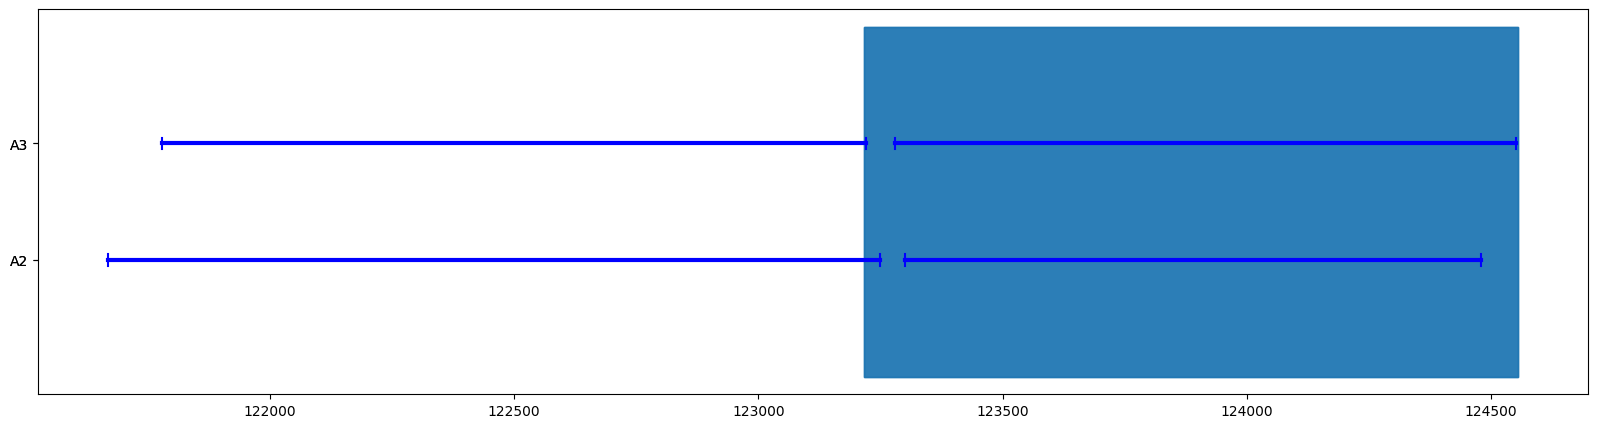

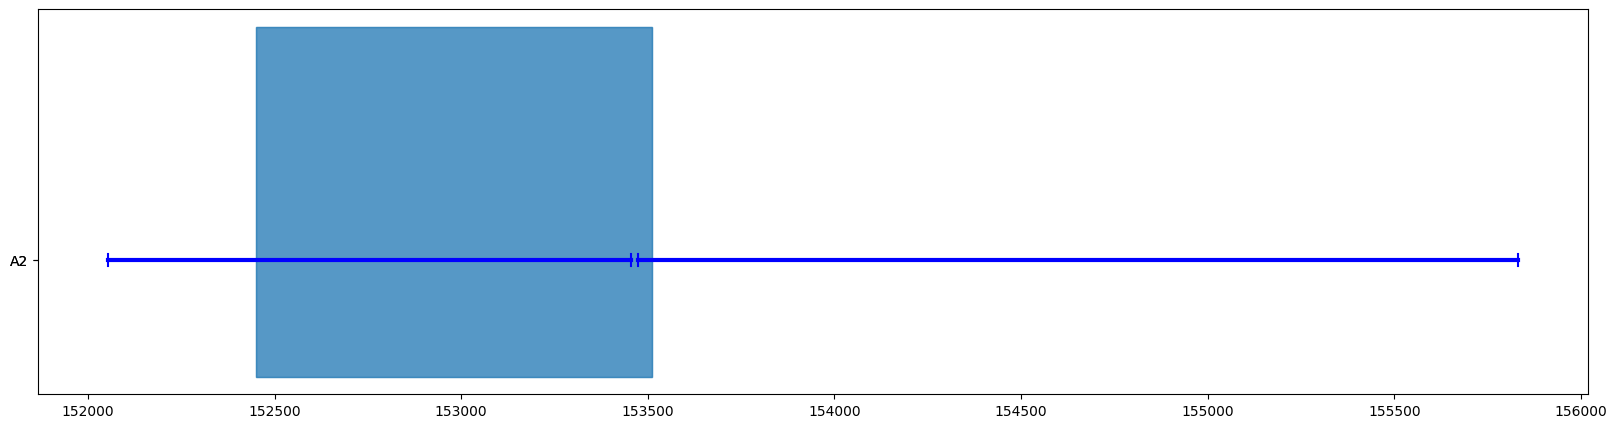

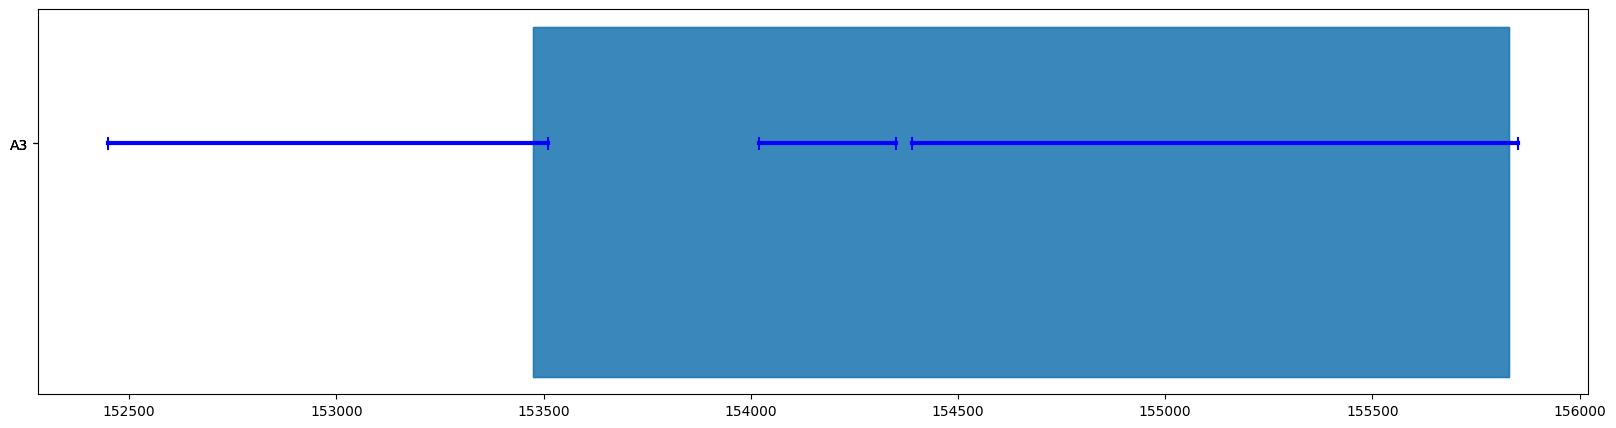

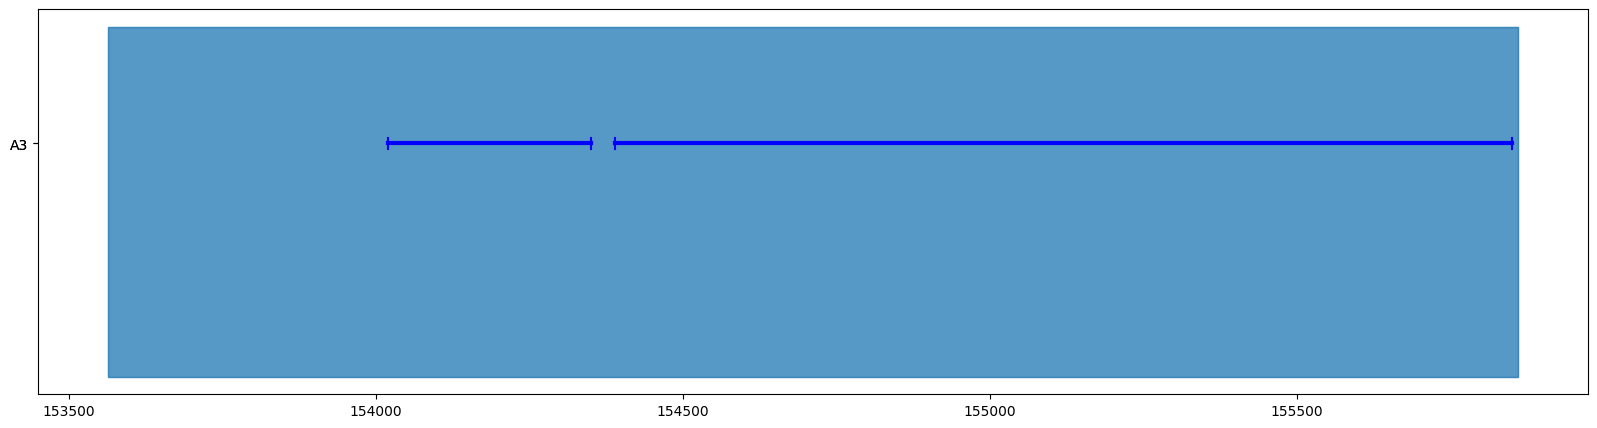

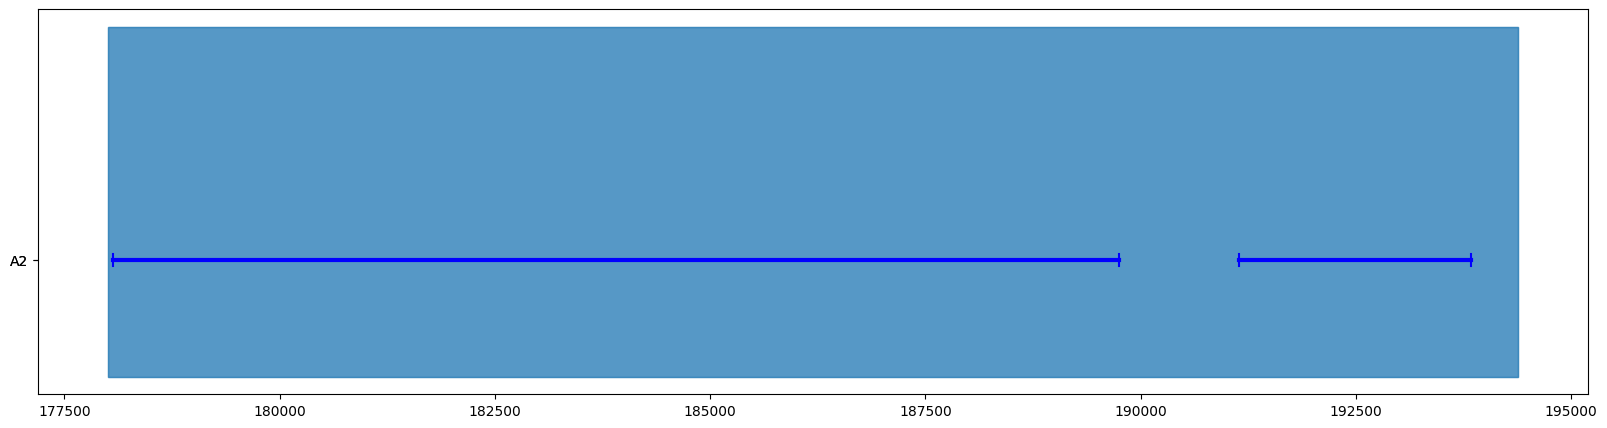

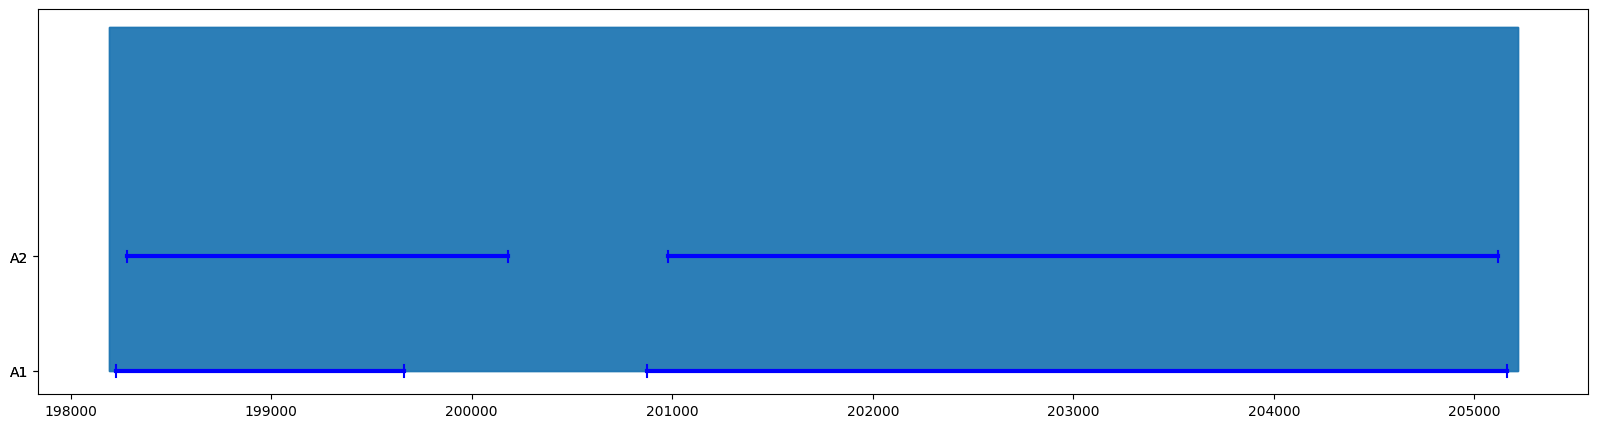

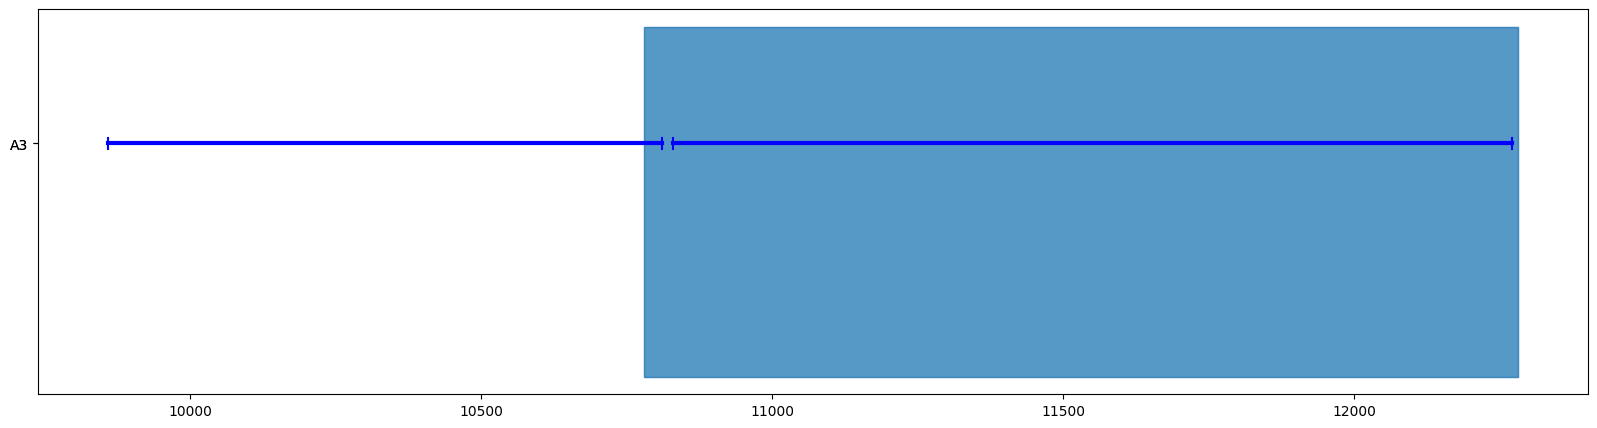

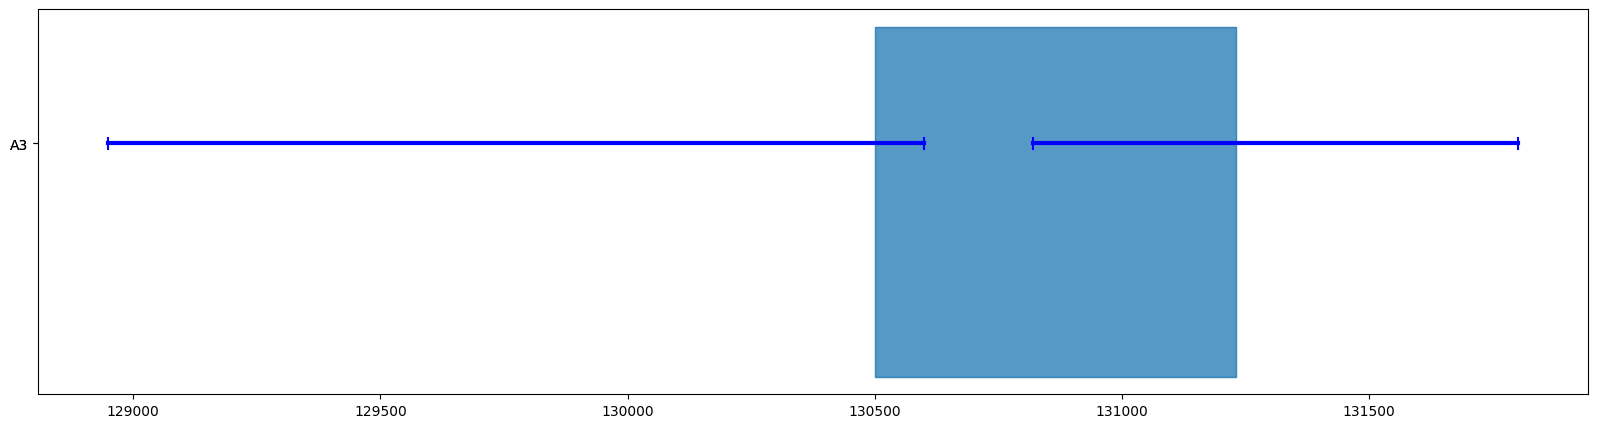

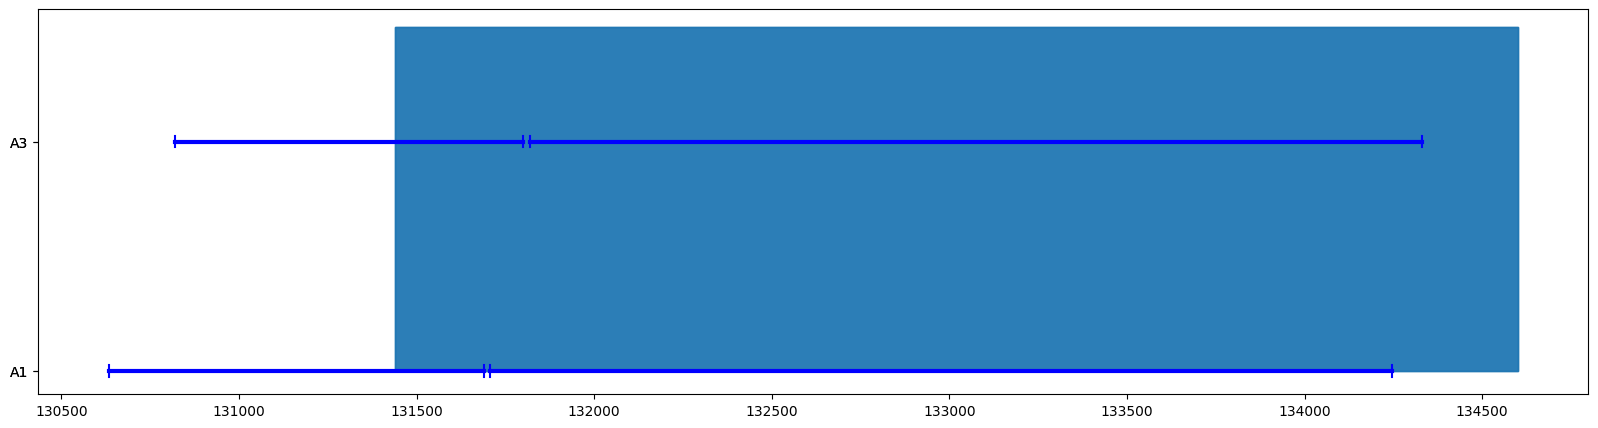

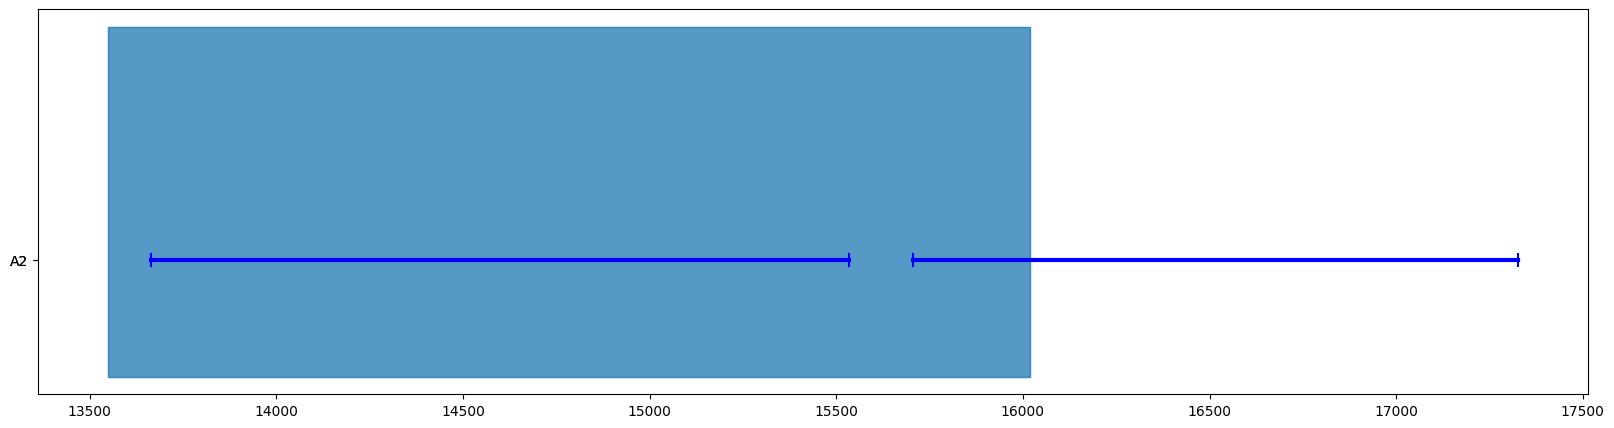

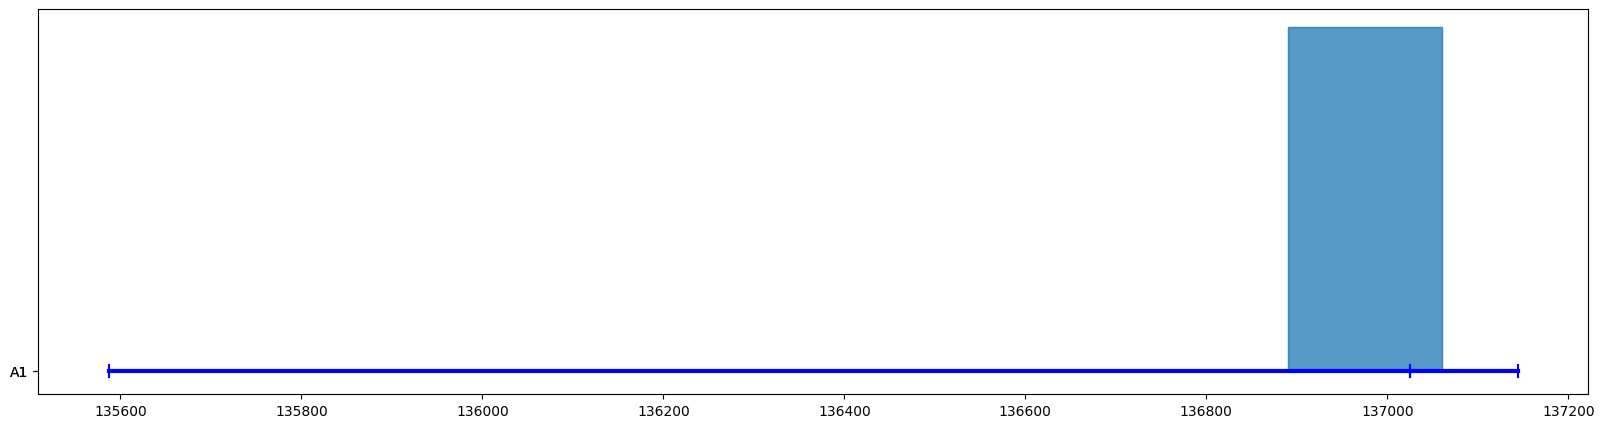

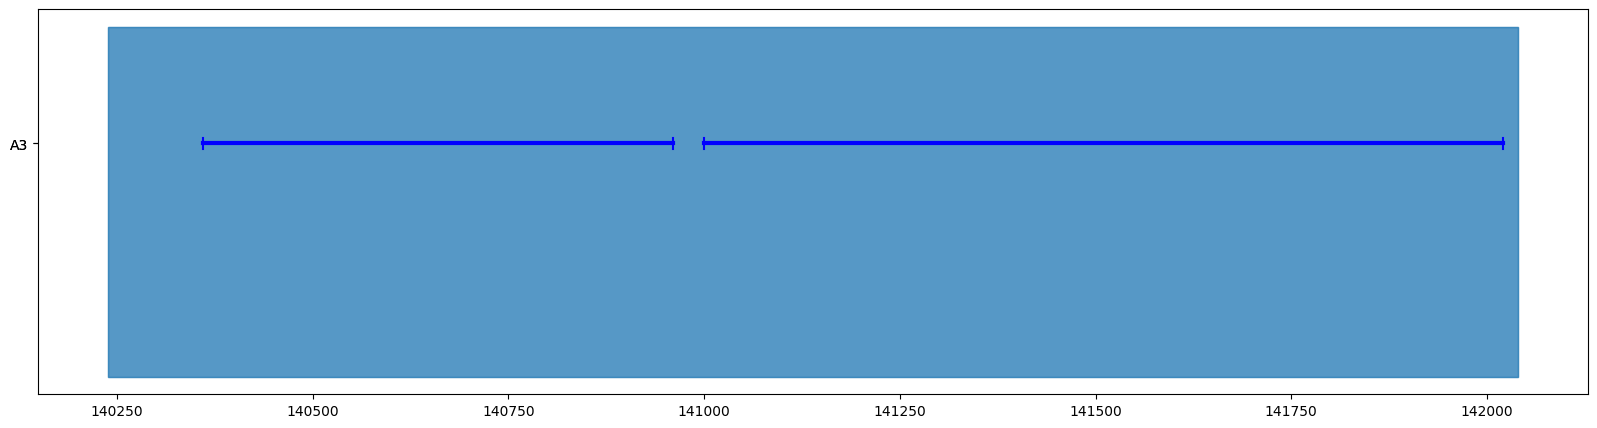

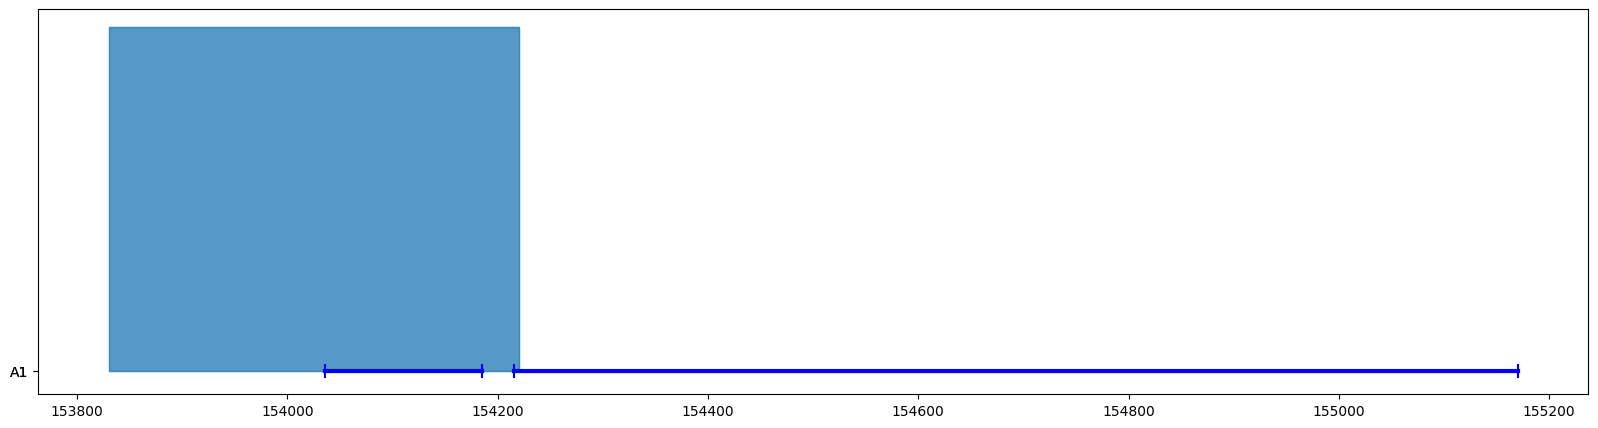

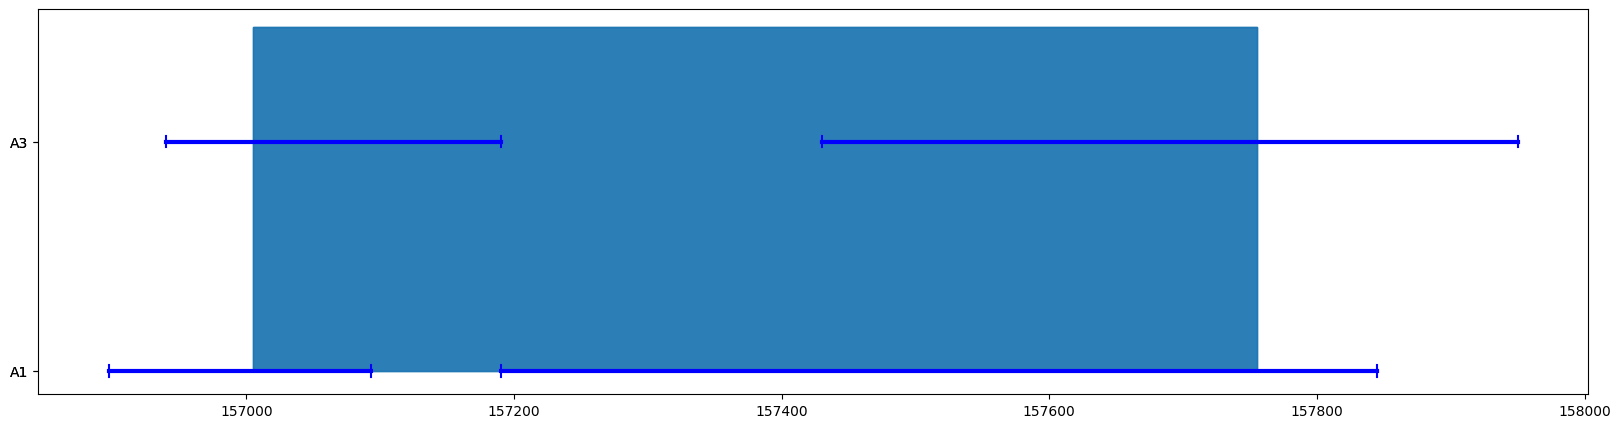

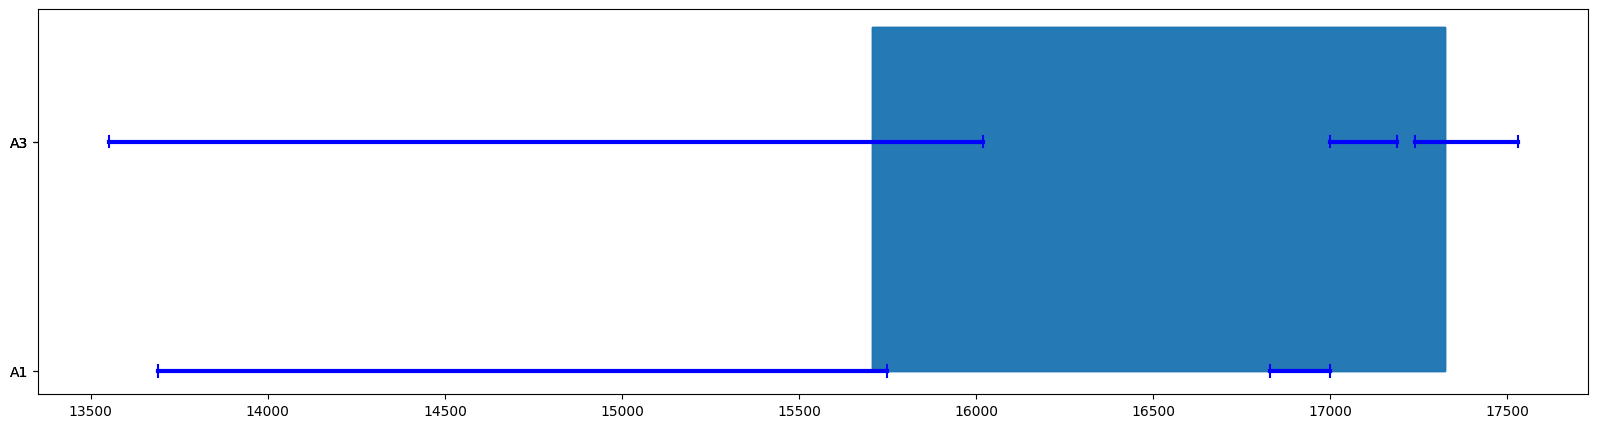

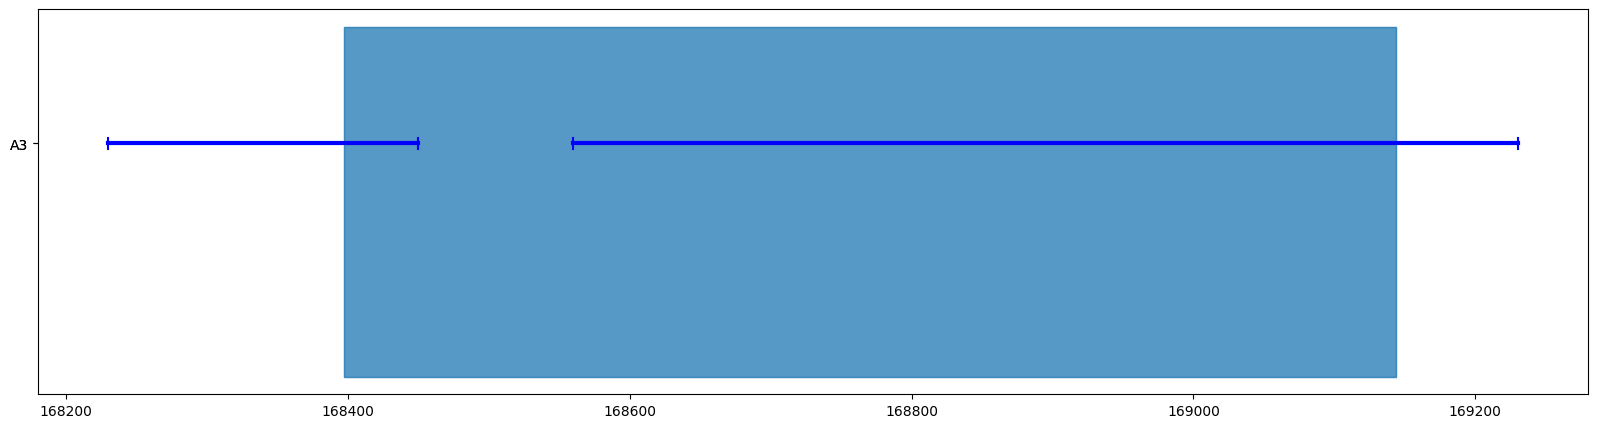

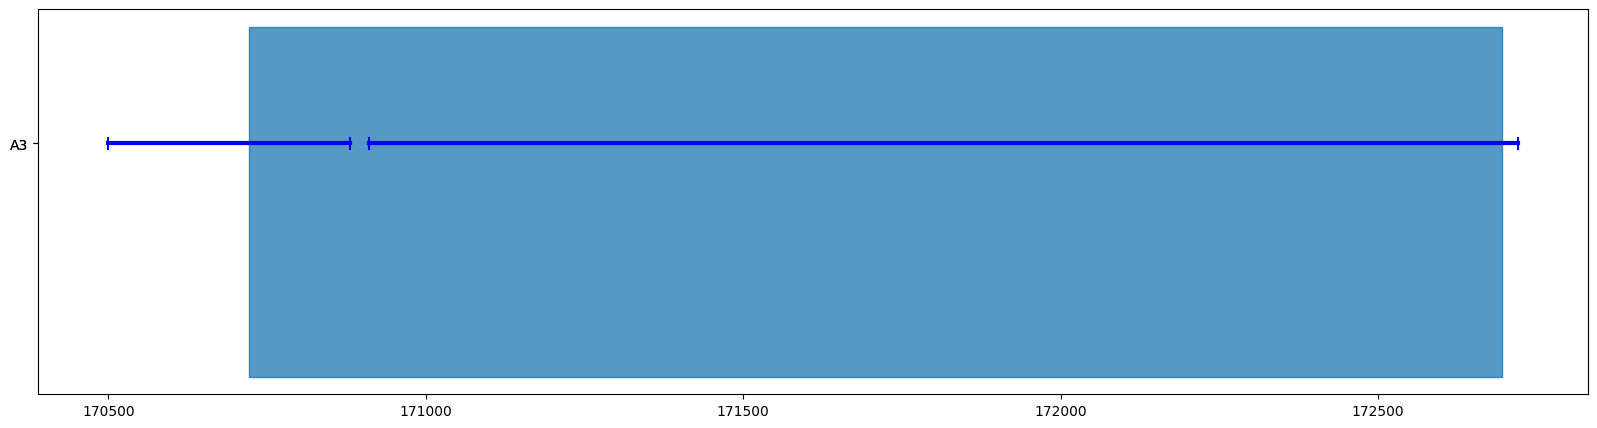

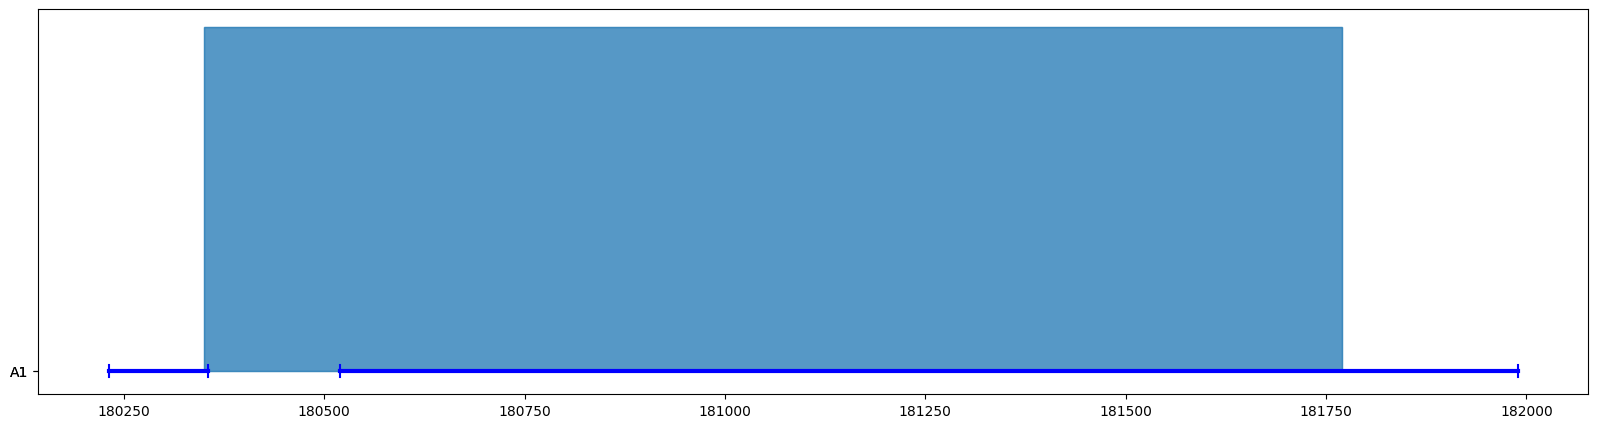

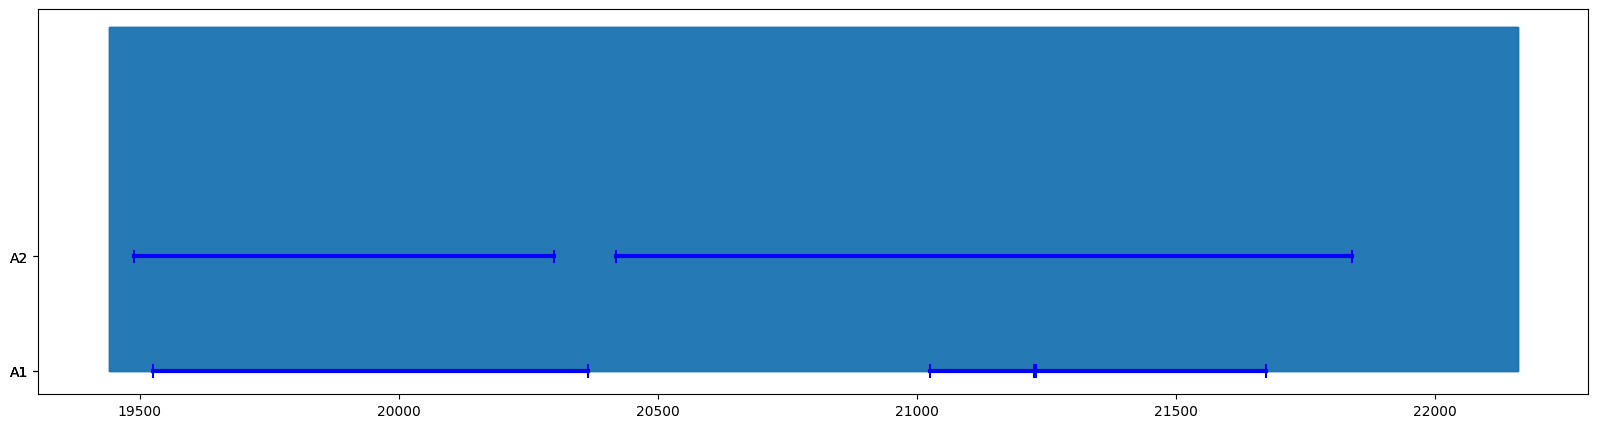

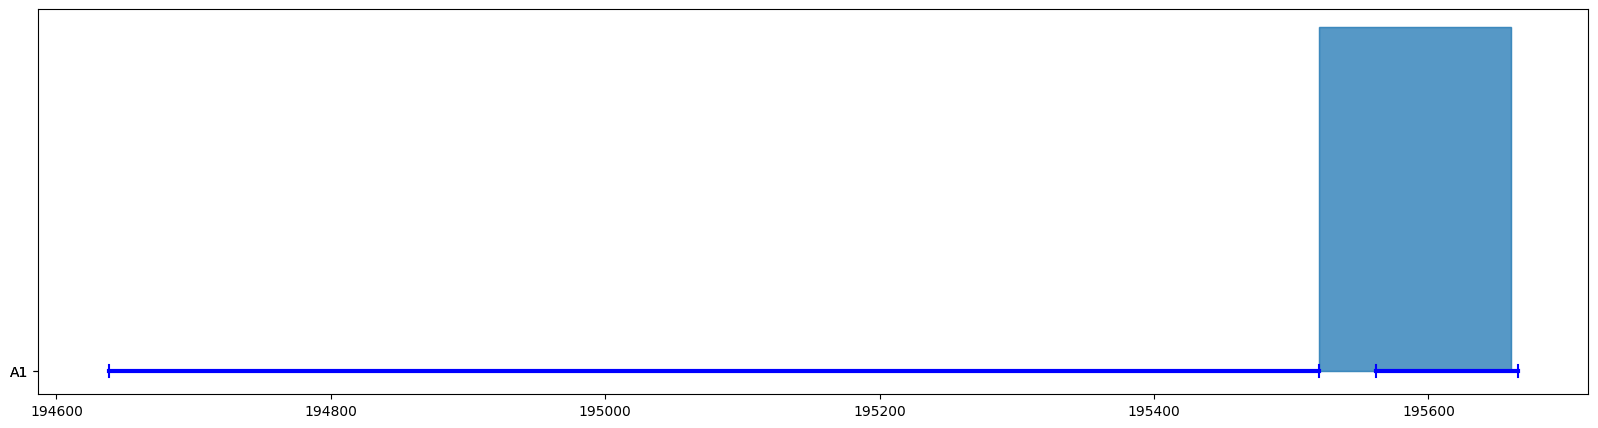

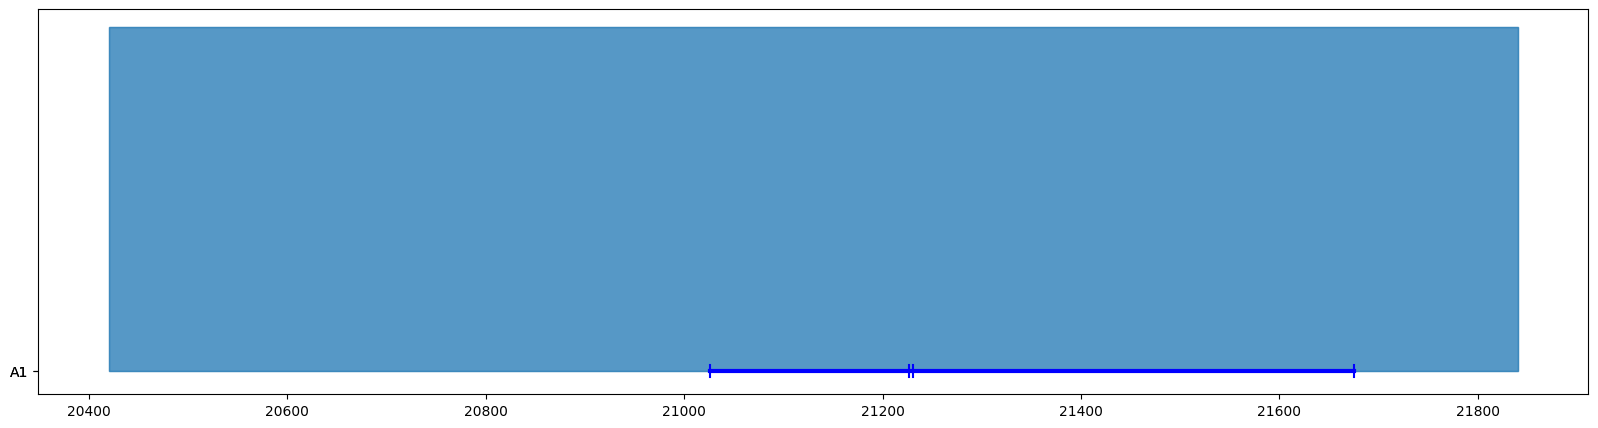

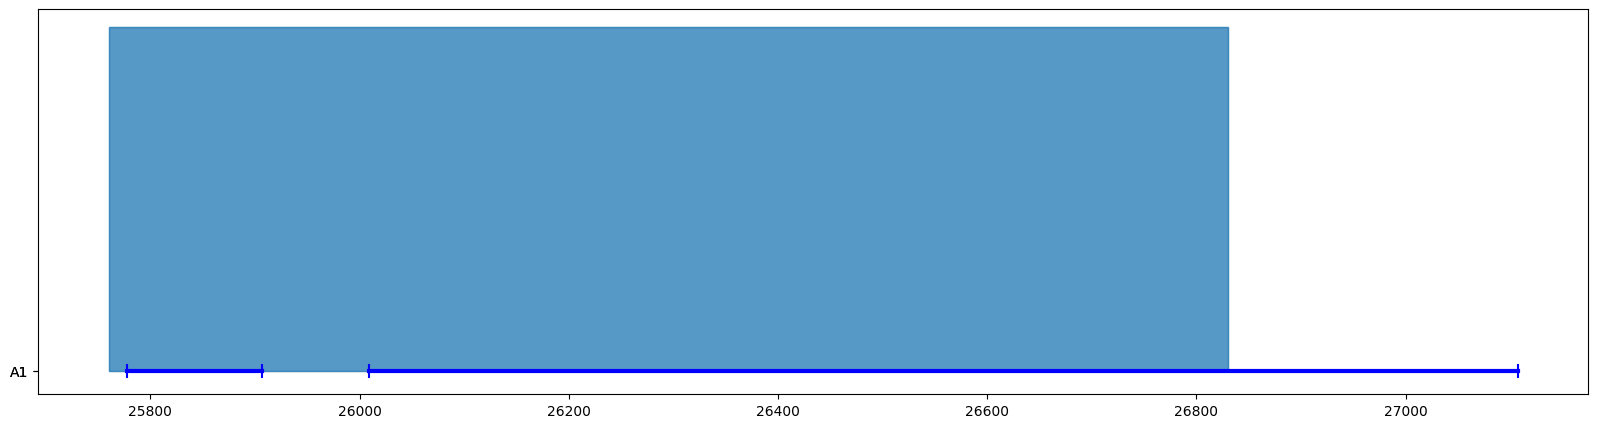

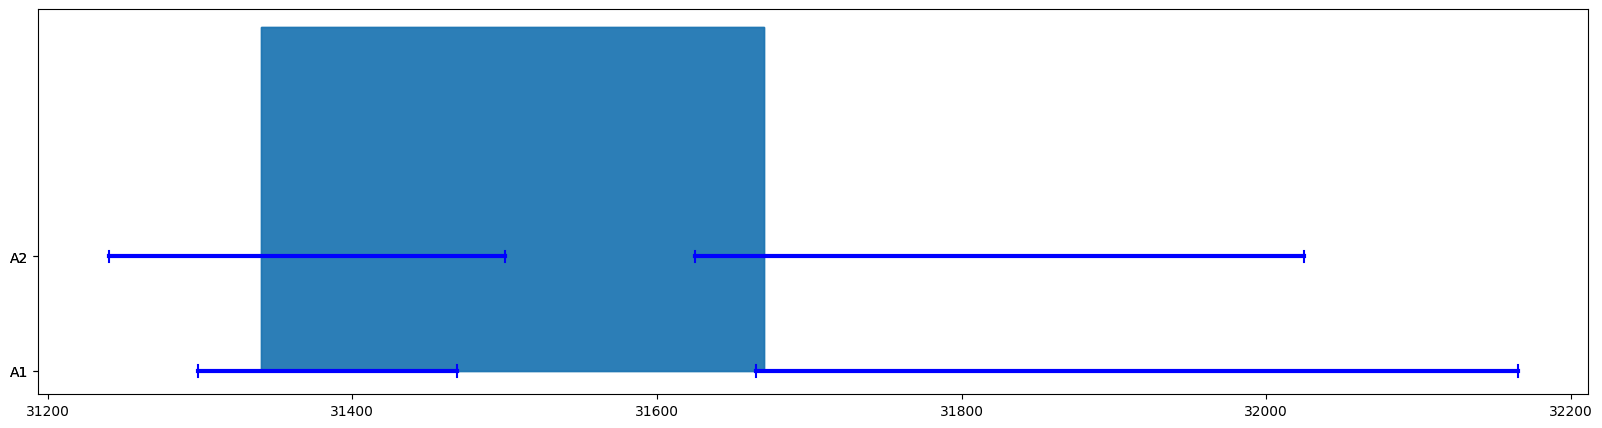

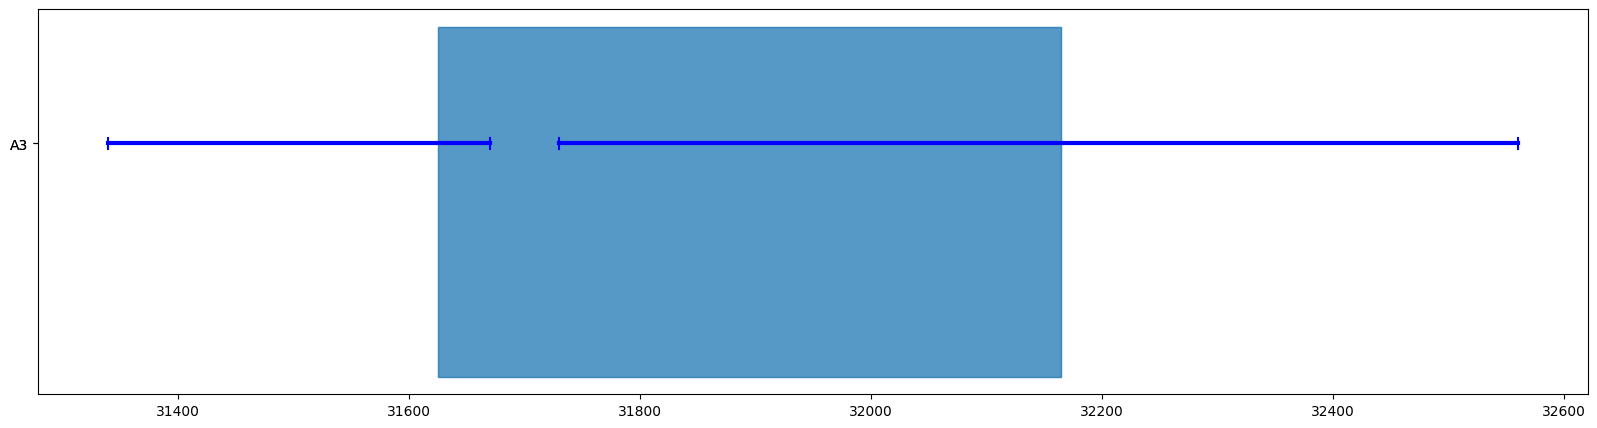

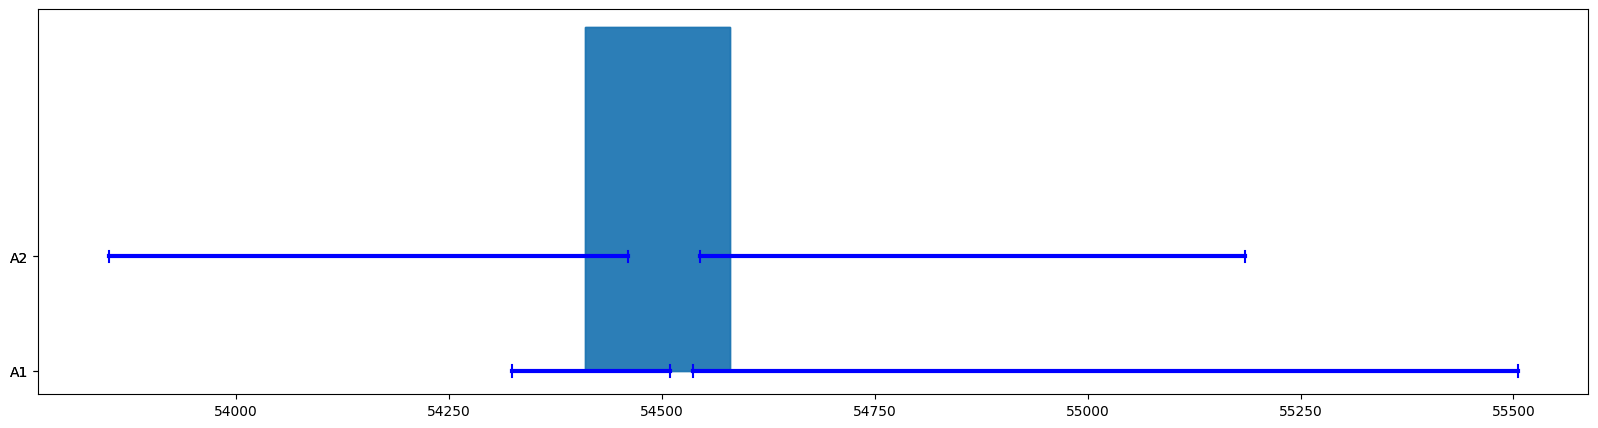

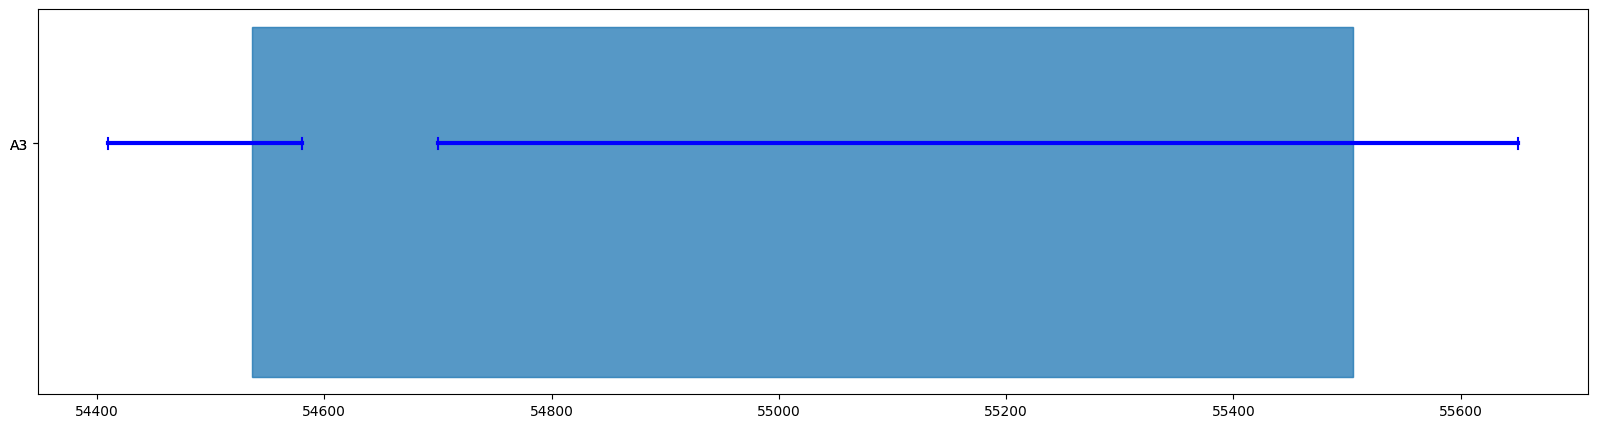

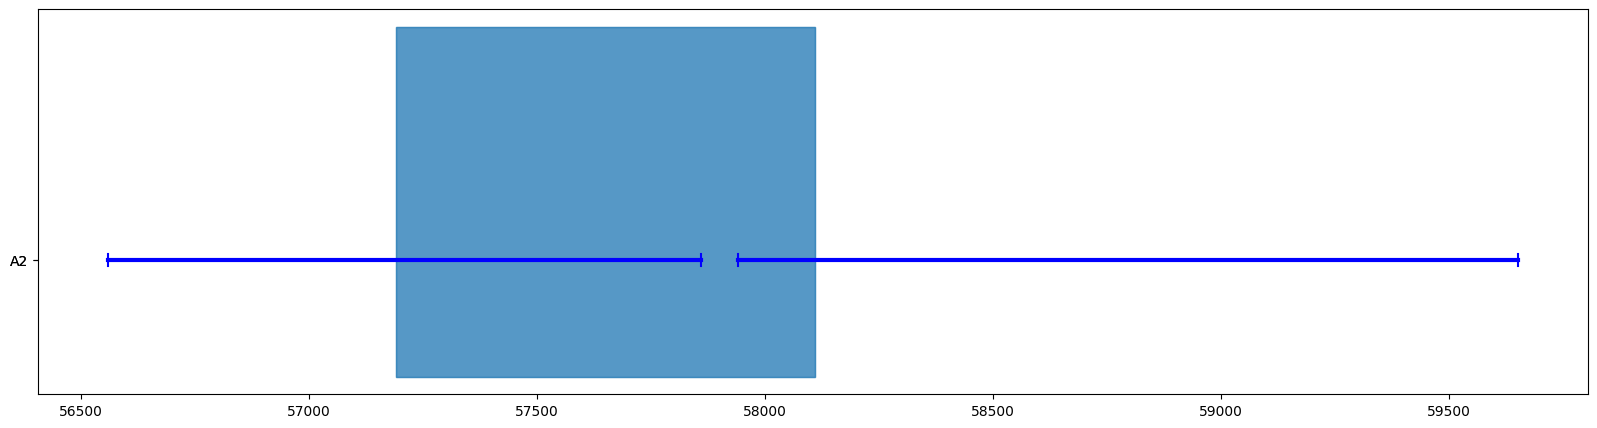

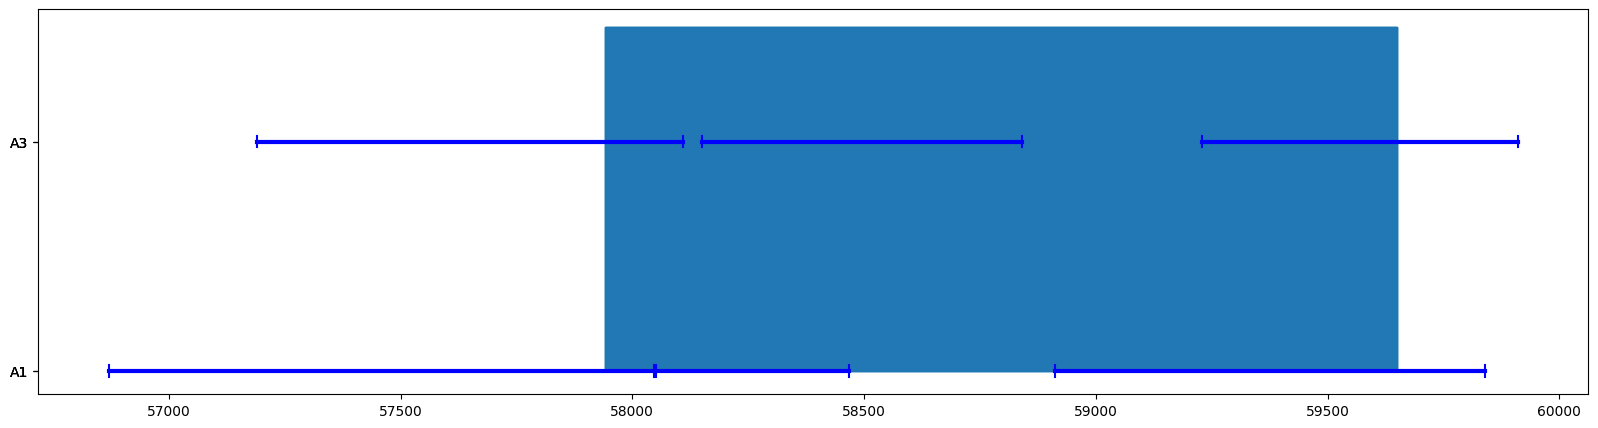

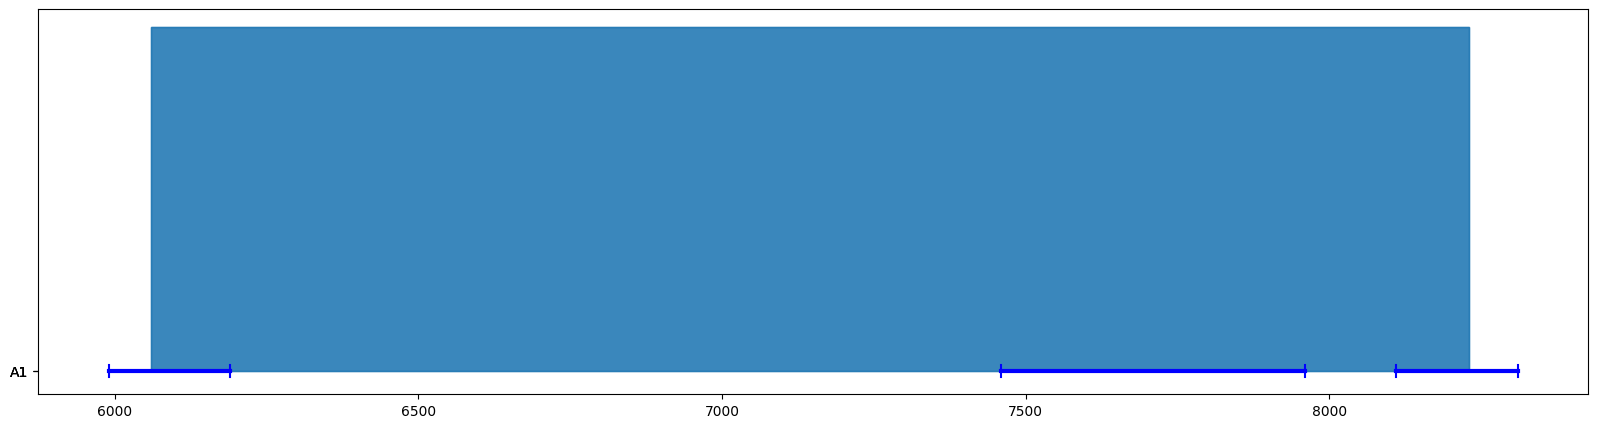

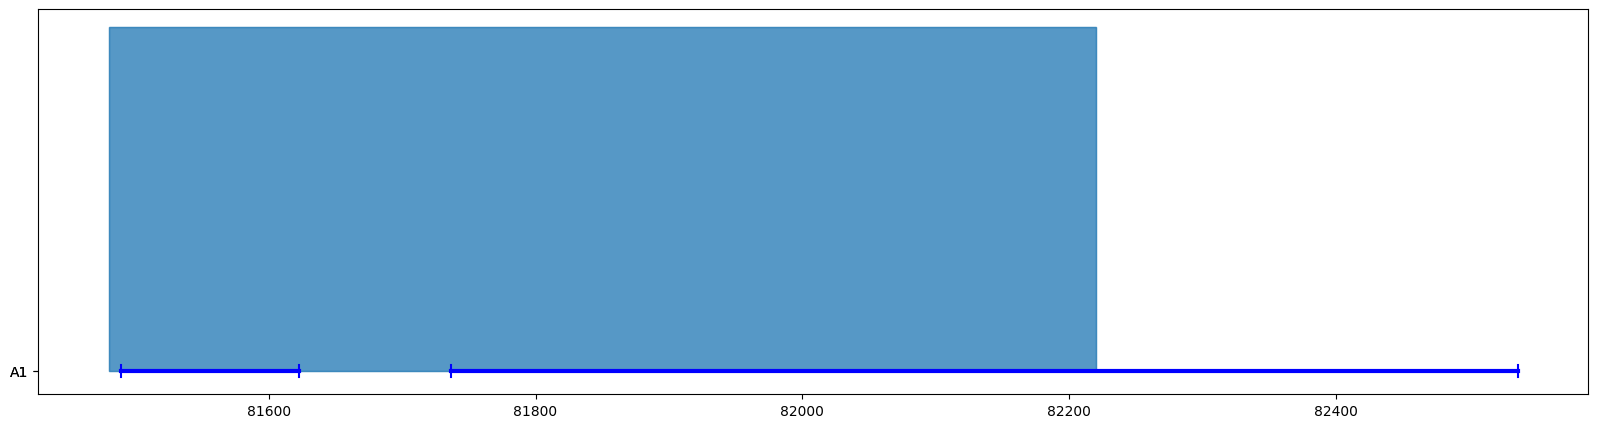

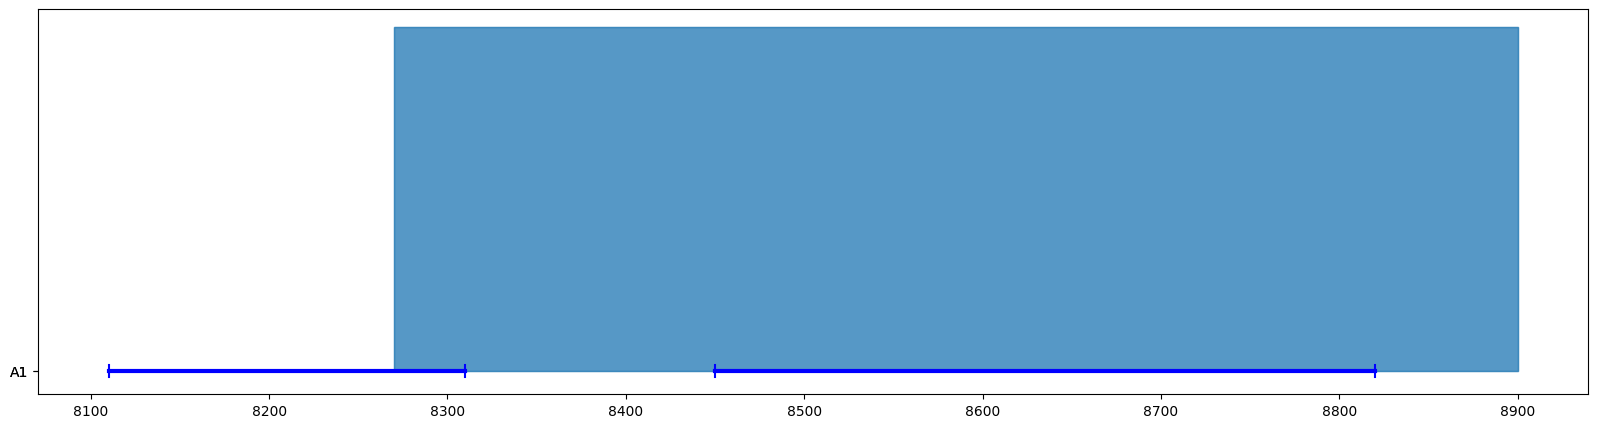

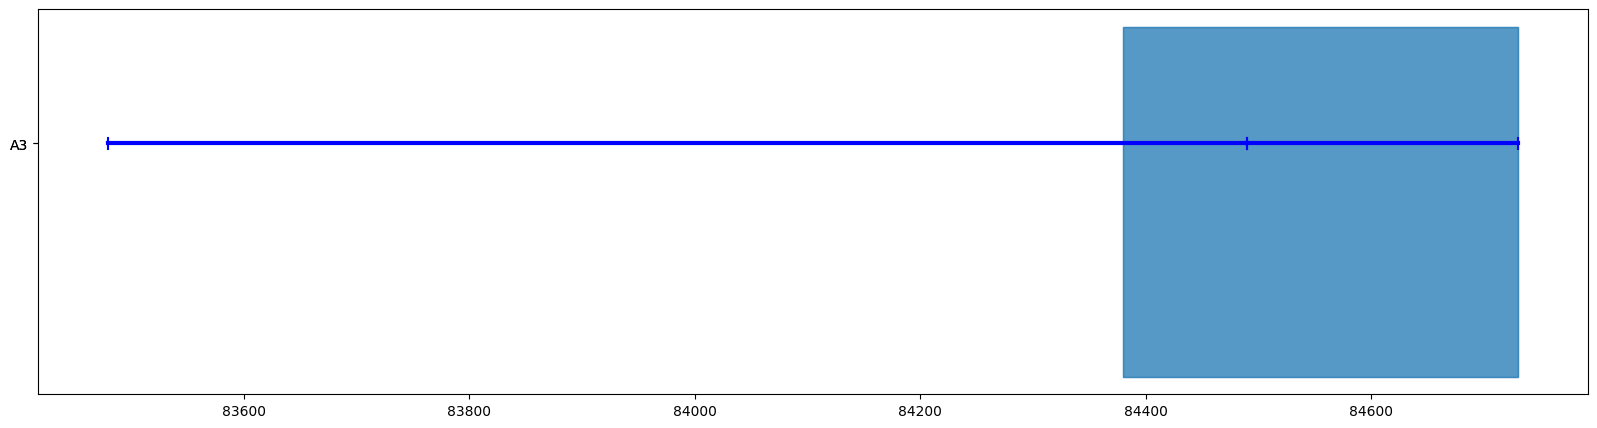

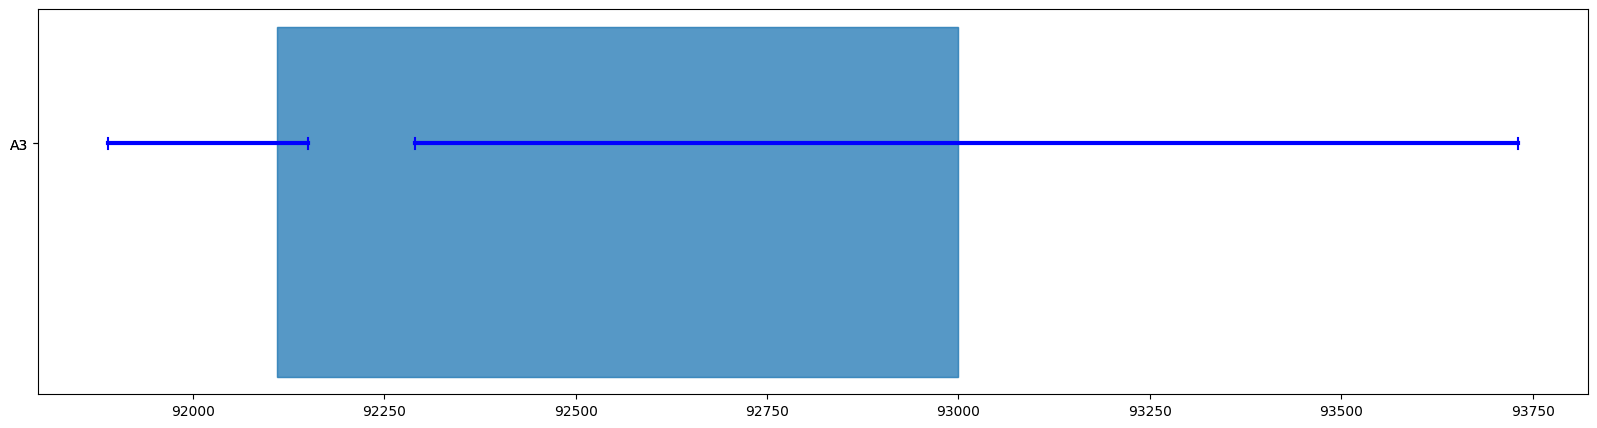

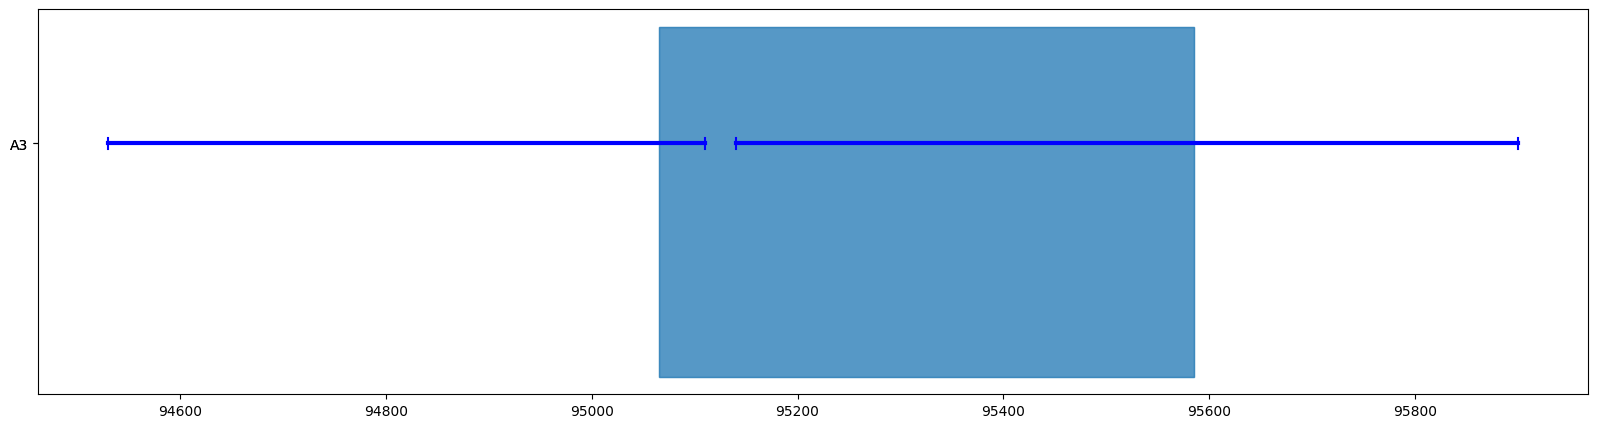

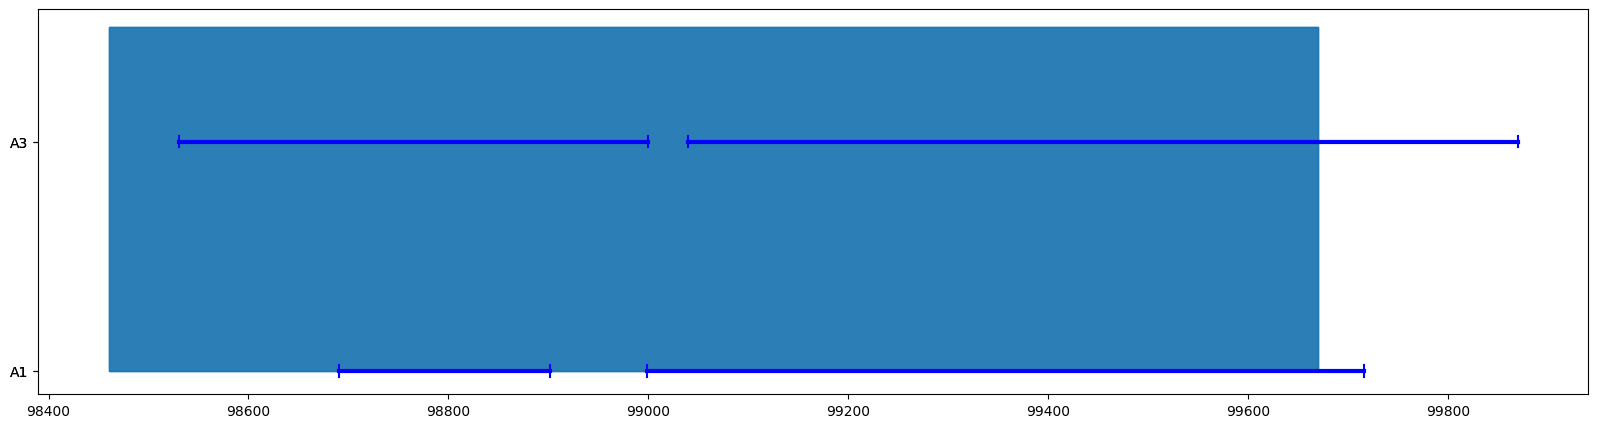

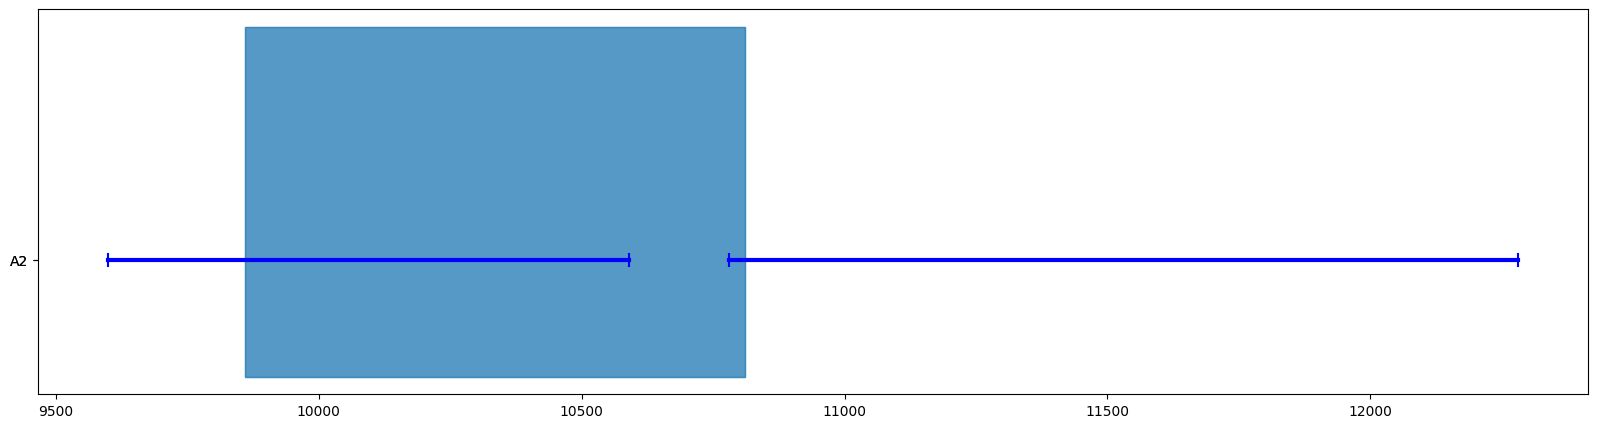

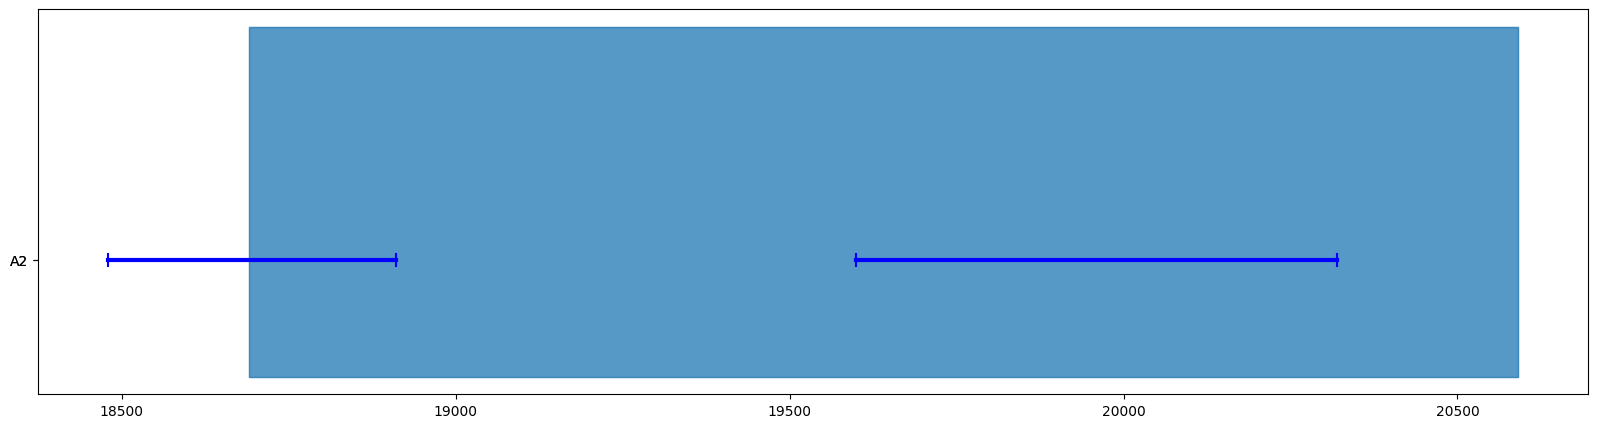

""


In [14]:
# plot the non unique combinations for all items in non_unique_combinations
# Assuming non_unique_combinations has columns 'origItemID' and 'annotator_id'
filtered_df = grannodf.merge(non_unique_combinations, on=['newItemID', 'annotator'])
filtered_df.iloc[:100].groupby('newItemID').apply(plot_ann)
# print(non_unique_combinations['newItemID'].nunique())
# print(non_unique_combinations['origItemID'].nunique())
# grannodf[(grannodf['newItemID'] == '25m-(12280, 19170)')]

In [20]:
# brute force method to combine annotations into items
def combine_annotations(df):
    resultdfs = []
    for item_id in df['origItemID'].unique():

        idf = df[df['origItemID'] == item_id]
        # sort idf by the start time of the timevr
        idf = idf.sort_values('timevr', ascending=True)
        events = idf['timevr'].values
        print(len(events))
        items = []
        for i, row in idf.iterrows():
            # check if timevr intersects with any of the events
            for event in events:

                if event.intersects(row['timevr']):
                    items.append(f"{item_id}-{event}")
                    resultdfs.append(pd.DataFrame({"origItemID":item_id, "annotations":row['annotations'],
                                       "annotator":row['annotator'], 
                                       "timevr":events, "goldTimeVR":row['goldTimeVR'], 
                                       "goldLabel":row['gold'], "newItemID":f"{item_id}-{event}"}))
                    
                    break
        
        
    return pd.concat(resultdfs)
combined_df = combine_annotations(grannodf)
combined_df.head()

37
50
186
21
40
36
726


71
4
11
140
10
54
127
158
312
39
183
425
33
239
17
32
21
32
44
368
486
16
61


,origItemID,annotations,annotator,timevr,goldTimeVR,goldLabel,newItemID
0,60m,B;0;0,A3,"(2360, 3230)",None,None,"60m-(2360, 3230)"
1,60m,B;0;0,A3,"(5800, 6560)",None,None,"60m-(2360, 3230)"
2,60m,B;0;0,A3,"(7470, 7860)",None,None,"60m-(2360, 3230)"
3,60m,B;0;0,A3,"(7730, 7880)",None,None,"60m-(2360, 3230)"
4,60m,B;0;0,A3,"(9830, 10380)",None,None,"60m-(2360, 3230)"


In [17]:
combined_df.shape

(3979, 7)

### Calculate the iaa using Time Span only 

#### On all A1, A2 and A3

In [10]:
grannodf.head()

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold
0,60m,"60m-(5800, 6560)","(5800, 6560)",A2,_;FG;1,"(5800, 6560)",None,None
1,60m,"60m-(9830, 10380)","(9830, 10380)",A2,_;HM;1,"(9830, 10380)",None,None
2,60m,"60m-(11100, 11630)","(11100, 11630)",A2,_;FG+HM;1,"(11100, 11630)",None,None
3,60m,"60m-(17120, 17460)","(17120, 17460)",A2,_;FG+HM;1,"(17120, 17460)",None,None
4,60m,"60m-(29220, 31020)","(29220, 31020)",A2,MUR;0;1,"(29220, 31020)",None,None


In [23]:


grannodf['newItemID'] = grannodf['newItemID'].astype('category').cat.codes
iaa = InterAnnotatorAgreement(annodf=grannodf, distance_fn=inv_iou, label_colname="timevr", item_colname="newItemID", uid_colname="annotator_id")
iaa.setup()
print(f'Krippendorff alpha: {iaa.get_krippendorff_alpha()}')
print(f'Ks : {iaa.get_ks()}')
print(f'Sigma: {iaa.get_sigma()}')


Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.4722280193753411
Ks : 0.8545501022494888
Sigma: 0.8548057259713702


In [12]:
# iaa.plot_distance_distributions()
# iaa.plot_matrix(show_grid=False)

#### Only between between A1 and A3

In [24]:
grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['annotator'].isin(['A1', 'A3'])]
grannodf_temp = grannodf_temp[~grannodf_temp['origItemID'].isin(['24fc'])]
# grannodf_temp['anotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=inv_iou, label_colname="timevr", item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup()
print(f'Krippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'Ks: {iaa_temp.get_ks()}')
print(f'Sigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.45142891250097483
Ks: 0.8006509357200976
Sigma: 0.7982099267697315


In [25]:
grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['annotator'].isin(['A2', 'A3'])]
grannodf_temp = grannodf_temp[~grannodf_temp['origItemID'].isin(['24fc'])]
# grannodf_temp['anotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=inv_iou, label_colname="timevr", item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup()
print(f'Krippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'Ks: {iaa_temp.get_ks()}')
print(f'Sigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.4239707936675772
Ks: 0.8306165839829908
Sigma: 0.8221119773210489


In [26]:
grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['annotator'].isin(['A2', 'A1'])]
grannodf_temp = grannodf_temp[~grannodf_temp['origItemID'].isin(['24fc'])]
# grannodf_temp['anotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=inv_iou, label_colname="timevr", item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup()
print(f'Krippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'Ks: {iaa_temp.get_ks()}')
print(f'Sigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.4363212549744554
Ks: 0.7411273486430062
Sigma: 0.7446068197633959


#### Aggregate Annotations

In [12]:
grannodf_c = grannodf.copy()
grannodf_c.shape

(3967, 8)

In [11]:
from stutter.utils import LabelMap
def aggregate_label(x):
    label_map = LabelMap()
    behaviour, tension = [], []
    for label in x:
        binary = label_map.labelfromstr(label)
        behaviour.append(binary[:-1])
        tension.append(binary[-1])
    #  sum and clip the values
    behaviour = np.clip(np.sum(behaviour,axis=0), 0, 1)
    # get the majority tension value either 1,2,3
    tension = max(set(tension), key=tension.count)
    # concatinate the behaviour and tension
    return label_map.strfromlabel(np.concatenate([behaviour, [tension]], axis=0))

def aggregate_timevr(x):
    # merge the time vector ranges
    return unionize_vectorrange_sequence(x)

def aggregate_gold(x):
    # get the first non-null value
    return next((i for i in x if i is not None), None)


aggregated_annotations = grannodf_c.groupby(['origItemID', 'newItemID', 'annotator']).agg({
                                    'annotations': lambda x: aggregate_label(x), 
                                    'timevr': lambda x: aggregate_timevr(x), 
                                    'gold':lambda x:aggregate_gold(x), 
                                    'goldTimeVR':lambda x:aggregate_gold(x)}).reset_index()
aggregated_annotations.head()

NameError: name 'grannodf_c' is not defined

In [29]:
grouped = aggregated_annotations.groupby(['origItemID', 'newItemID', 'annotator']).size().reset_index(name='counts').sort_values('counts', ascending=False)
non_unique_combinations = grouped[grouped['counts'] > 1]
non_unique_combinations

,origItemID,newItemID,annotator,counts


In [24]:
def expand_df(aggregated_annotations, item_col, annotator_col):
    # Create a MultiIndex with all combinations of item_id and annotator_id
    origitem = aggregated_annotations['origItemID'].unique()
    item_ids = aggregated_annotations[item_col].unique()
    annotator_ids = aggregated_annotations[annotator_col].unique()
    multi_index = pd.MultiIndex.from_product([origitem, item_ids, annotator_ids], names=['origItemID', item_col, annotator_col])

    # Reindex the DataFrame to include all combinations
    aggregated_annotations = aggregated_annotations.set_index(['origItemID', item_col, annotator_col]).reindex(multi_index).reset_index()

    # Fill missing values with 0
    aggregated_annotations.fillna(0, inplace=True)
    return aggregated_annotations


### Compute IAA per class

In [9]:
label_columns = ['SR','ISR','MUR','P','B', 'V', 'FG', 'HM', 'ME']
from stutter.utils import LabelMap
label_map = LabelMap()
def get_class_Value(row, c):
    class_idx = label_map.labeltoidx[c]
    return label_map.labelfromstr(row)[class_idx]

In [16]:

def simple_distance(x, y):
    return 1 if x != y else 0

for c in label_columns:
    grannodf_temp =  grannodf.copy()
    grannodf_temp = grannodf_temp[grannodf_temp['annotator'].isin(['A1', 'A2', 'A3'])]
    grannodf_temp['annotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
    grannodf_temp['newItemID'] = grannodf_temp['newItemID'].astype('category').cat.codes
    grannodf_temp[c] = grannodf_temp['annotations'].apply(lambda x:get_class_Value(x, c))
    # grannodf_temp = expand_df(grannodf_temp, 'newItemID', 'annotator_id')
    iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=simple_distance, label_colname=c, item_colname="newItemID", uid_colname="annotator_id")
    iaa_temp.setup()
    print(f'evaluating {c}')
    print(f'\tKrippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
    print(f'\tKs: {iaa_temp.get_ks(fast=False)}')
    print(f'\tSigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
evaluating SR
	Krippendorff alpha: 0.35559566787003616
	Ks: 0.23677837658109468
	Sigma: 0.8120558041589891
Calculating same-item distances
Calculating different-item distances
evaluating ISR
	Krippendorff alpha: 0.05739514348785868
	Ks: 0.1848249539352461
	Sigma: 0.7752040010529087
Calculating same-item distances
Calculating different-item distances
evaluating MUR
	Krippendorff alpha: 0.27611940298507465
	Ks: 0.09768609467865509
	Sigma: 0.9234008949723611
Calculating same-item distances
Calculating different-item distances
evaluating P
	Krippendorff alpha: 0.5766550522648084
	Ks: 0.2634574195425389
	Sigma: 0.8720715977888918
Calculating same-item distances
Calculating different-item distances
evaluating B
	Krippendorff alpha: 0.43005497861942577
	Ks: 0.3249914797522893
	Sigma: 0.7544090550144775
Calculating same-item distances
Calculating different-item distances
evaluating V
	Krippendorff alpha: 0.2100061766522544
	K

In [19]:
def precision(x,y):
    if isinstance(x,list):
        tp = sum([a==b for a,b in zip(x,y)])
        fp = sum([a!=b for a,b in zip(x,y)])
        return tp / ((tp + fp)+1e-6)
    else:
        return x == y

def recall(x,y):
    if isinstance(x,list):
        tp = sum([a==b for a,b in zip(x,y)])
        fn = sum([a!=b for a,b in zip(x,y)])
        return tp / ((tp + fn)+1e-6)
    else:
        return x == y

def f1_score(x,y):
    p = precision(x,y)
    r = recall(x,y)
    return 2 * (p * r) / ((p + r)+1e-6)

def inv_f1_score(x,y):
    return 1 - f1_score(x,y)

def binary_dist(x,y):
    if isinstance(x, list):
        return sum([simple_distance(a,b) for a,b in zip(x,y)])/len(x)
    else:
        return simple_distance(x,y)

def rmse(x,y):
    return np.sqrt(np.mean((x-y)**2))

def euc_dist(x,y):
    if isinstance(x, list):
        return np.mean([rmse(a,b) for a,b in zip(x,y)])
    return rmse(x,y)

In [17]:

def weighted_sum(x,y):
    _iou = iou(x[0],y[0])
    bd = binary_dist(x[1],y[1])
    return 0.5 *(1 - _iou) + 0.5 * bd

def new_metric(x,y):
    _iou = iou(x[0],y[0])
    bd = binary_dist(x[1],y[1])
    return 1 - (_iou * (1-bd))

In [14]:
iaa_temp.expected_distances.sum(), iaa_temp.observed_distances.shape

(2506.7194801323426, (3799,))

In [25]:
grannodf_temp =  grannodf.copy()
# samples = grannodf_temp['origItemID'].sample(10).values
# grannodf_temp = grannodf_temp[grannodf_temp['origItemID'].isin(samples)]
grannodf_temp = grannodf_temp[grannodf_temp['annotator'].isin(['A1', 'A2', 'A3'])]
grannodf_temp['annotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
grannodf_temp['newItemID'] = grannodf_temp['newItemID'].astype('category').cat.codes
grannodf_temp['origItemID'] = grannodf_temp['origItemID'].astype('category').cat.codes
grannodf_temp['SR'] = grannodf_temp['annotations'].apply(lambda x:get_class_Value(x, 'SR'))
# grannodf_temp['labelarray'] = grannodf_temp.apply(lambda row:[row['timevr'],label_map.labelfromstr(row['annotations'])], axis=1)
grannodf_temp['labelarray'] = grannodf_temp['annotations'].apply(lambda x:label_map.labelfromstr(x))
grannodf_temp['core'] = grannodf_temp['annotations'].apply(lambda x:label_map.get_core(x)[1])
grannodf_temp['secondary'] = grannodf_temp['annotations'].apply(lambda x:label_map.get_secondary(x)[1])
# grannodf_temp = expand_df(grannodf_temp, 'newItemID', 'annotator_id')
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=euc_dist, label_colname='labelarray', item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup(subsample_expected_distances=True)
print(f'evaluating core using binary distance')
print(f'\tKrippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'\tKs: {iaa_temp.get_ks(fast=False)}')
print(f'\tSigma: {iaa_temp.get_sigma(debug=False)}')


Calculating same-item distances
Calculating different-item distances
evaluating core using binary distance
	Krippendorff alpha: 0.26951507983441736
	Ks: 0.5799515107853868
	Sigma: 0.2782311134509081


In [13]:
# make dataframe from predictions
label_map = LabelMap()
def get_class_Value(row, c):
    class_idx = label_map.labeltoidx[c]
    return label_map.labelfromstr(row)[class_idx]

def compute_fleiss_kappa(df, item_col, annotator_col, category_col):
    # Step 1: Group by item and category, and count the number of ratings per category for each item
    df[category_col] = df['label'].apply(lambda x:get_class_Value(x, category_col))
    grouped = df.groupby([item_col, category_col]).size().unstack(fill_value=0)
    
    # Step 2: Convert the grouped DataFrame to a matrix
    matrix = grouped.values
    
    # Step 3: Compute Fleiss' Kappa
    N, k = matrix.shape  # N is the number of items, k is the number of categories
    n = np.sum(matrix[0])  # n is the number of raters per item

    # Calculate p_j
    p_j = np.sum(matrix, axis=0) / (N * n)

    # Calculate P_i
    P_i = (np.sum(matrix * (matrix - 1), axis=1) / (n * (n - 1)))

    # Calculate mean agreement over all items
    P_bar = np.mean(P_i)

    # Calculate expected agreement by chance
    P_e_bar = np.sum(p_j ** 2)

    # Calculate Fleiss' Kappa
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa

compute_fleiss_kappa(grannodf, 'newItemID', 'anotator', 'FP')

-1.527373252491237

In [8]:
grannodf

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold,annotator_id
0,60m,"60m-(5800, 6560)","(5800, 6560)",A2,_;FG;1,"(5800, 6560)",None,None,1
1,60m,"60m-(9830, 10380)","(9830, 10380)",A2,_;HM;1,"(9830, 10380)",None,None,1
2,60m,"60m-(11100, 11630)","(11100, 11630)",A2,_;FG+HM;1,"(11100, 11630)",None,None,1
3,60m,"60m-(17120, 17460)","(17120, 17460)",A2,_;FG+HM;1,"(17120, 17460)",None,None,1
4,60m,"60m-(29220, 31020)","(29220, 31020)",A2,MUR;0;1,"(29220, 31020)",None,None,1
...,...,...,...,...,...,...,...,...,...
56,24ma,"24ma-(98435, 98755)","(98435, 98755)",A2,ISR;0;1,"(98360, 100140)",None,None,1
57,24ma,"24ma-(98435, 98755)","(98435, 98755)",A3,MUR;0;0,"(98539, 100070)",None,None,2
58,24ma,"24ma-(98435, 98755)","(98435, 98755)",A1,P;0;0,"(98435, 98755)",None,None,0
59,24ma,"24ma-(105284, 105521)","(105284, 105521)",A2,SR;0;1,"(104800, 105840)",None,None,1


### Calculating IAA over tention using using eucledian distance

Calculating same-item distances
Calculating different-item distances
evaluating T
	Krippendorff alpha: 0.18480043739748508
	Ks: 0.3840390823069783


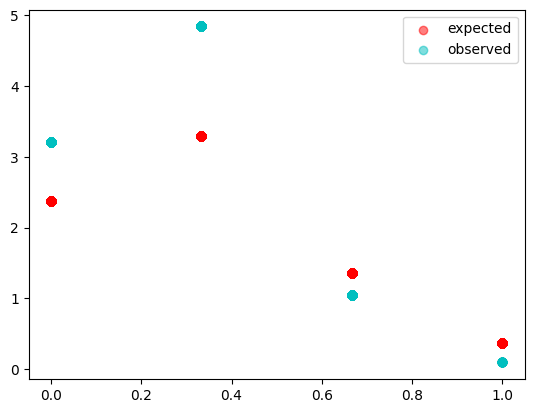

	Sigma: 0.3493024480126349


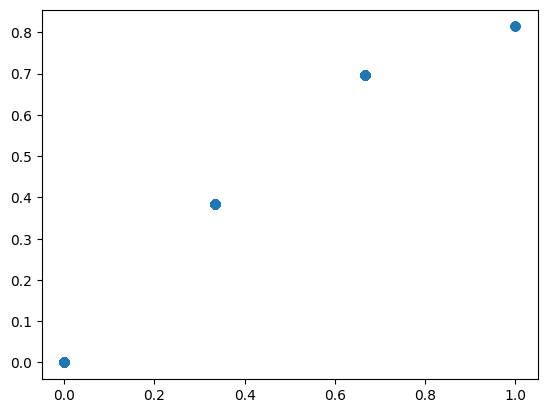

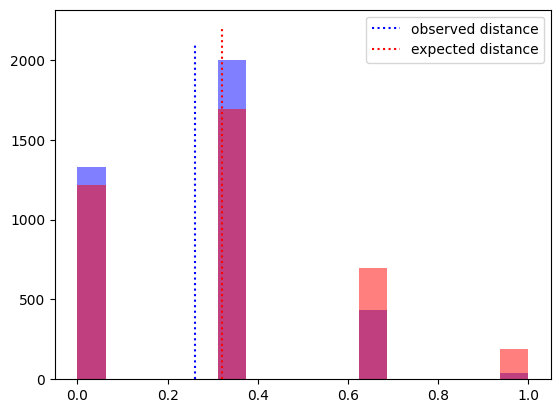

In [26]:
def rmse(x, y):
    x = x/3
    y = y/3
    return np.sqrt(np.mean((x - y) ** 2))

def euclidean_distances(x, y):
    return rmse(x, y)

grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['annotator'].isin(['A1', 'A2', 'A3'])]
grannodf_temp['annotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
grannodf_temp['newItemID'] = grannodf_temp['newItemID'].astype('category').cat.codes
grannodf_temp['T'] = grannodf_temp['annotations'].apply(lambda x:get_class_Value(x, 'T'))
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=euclidean_distances, label_colname='T', item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup()
print(f'evaluating T')
print(f'\tKrippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'\tKs: {iaa_temp.get_ks(fast=False)}')
print(f'\tSigma: {iaa_temp.get_sigma(debug=True)}')

In [53]:
df = pd.read_csv('../datasets/fluencybank/ds_5/reading/total_df.csv')
df = df[~df['annotator'].isin(['A1', 'A2', 'A3', 'Gold'])]
df.head()

,media_file,clip_id,clip_start,clip_end,annotator,start,end,FP,SR,ISR,MUR,P,B,NV,V,FG,HM,ME,T


In [82]:
def get_class_Value(x, c):
    if x is np.nan:
        return 0
    class_idx = label_map.labeltoidx[c]
    return label_map.labelfromstr(x)[class_idx]
temp_grannodf = grannodf.copy()
temp_grannodf = temp_grannodf[temp_grannodf['annotator'].isin(['A1', 'A3'])]
pivot_df = grannodf.pivot_table(index='newItemID', columns='annotator', values='annotations', aggfunc='first')
pivot_df[['A1', 'A3']] = pivot_df[['A1', 'A3']].applymap(lambda x: get_class_Value(x, 'B'))
pivot_df.values
def compute_fleiss_kappa(matrix):
    N, n = matrix.shape  # N is the number of items, n is the number of annotators

    # Transform the matrix to count the number of annotators who assigned each category (0 or 1) to each item
    transformed_matrix = np.zeros((N, 2), dtype=int)
    for i in range(N):
        transformed_matrix[i, 0] = np.sum(matrix[i] == 0)
        transformed_matrix[i, 1] = np.sum(matrix[i] == 1)
    print(transformed_matrix.shape, [np.max(transformed_matrix, axis=1)<2])
    # Calculate p_j (proportion of all assignments to each category)
    p_j = np.sum(transformed_matrix, axis=0) / (N * n)
    P_i = (np.sum(transformed_matrix * (transformed_matrix - 1), axis=1) / (n * (n - 1)))
    P_bar = np.mean(P_i)
    P_e_bar = np.sum(p_j ** 2)
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa

compute_fleiss_kappa(pivot_df.values)

(1281, 2) [False False False ... False False False]


-0.05075112785542596

In [17]:
import sys
sys.path.append('../annotationmodeling')
from agreement import InterAnnotatorAgreement

grannodf['newItemID'] = grannodf['newItemID'].astype('category').cat.codes

def inv_score(x, y):
    return score(x, y)

iaa = InterAnnotatorAgreement(annodf=grannodf, distance_fn=normalized_hamming_distance, label_colname="annotations", item_colname="newItemID", uid_colname="anotator_id")
iaa.setup()
print(f'Krippendorff alpha: {iaa.get_krippendorff_alpha()}')
print(f'Ks : {iaa.get_ks()}')
print(f'Sigma: {iaa.get_sigma()}')


Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.16325301204819276
Ks : 0.15063829787234043
Sigma: 0.07829787234042551


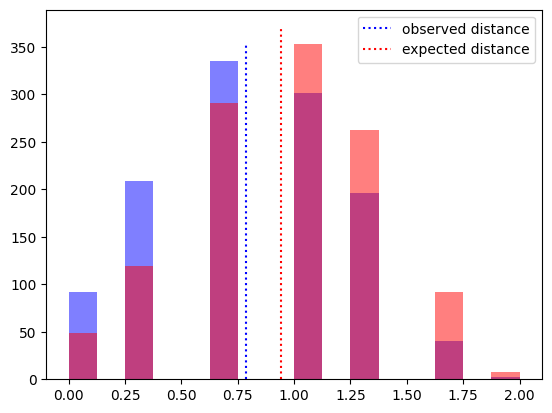

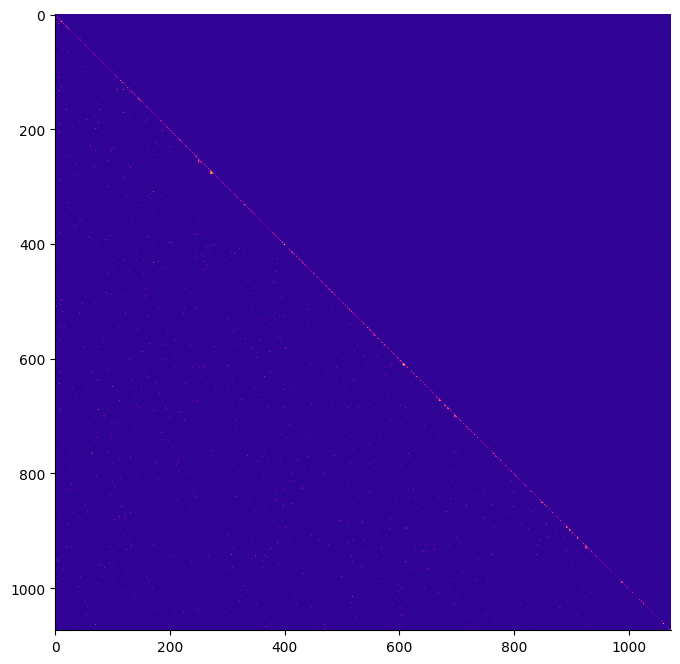

In [18]:
iaa.plot_distance_distributions()
iaa.plot_matrix(show_grid=False)

In [5]:

import json
df = pd.read_csv('../datasets/fluencybank/our_annotations/reading/csv/gran_data_total.csv')
# open split file and select only train examples
with open('../datasets/fluencybank/our_annotations/reading_split.json', 'r') as f:
    s_file = json.load(f)
train_examples = s_file['train']
df_train = df[df['origItemID'].isin(train_examples)]
df_train.to_csv('../datasets/fluencybank/our_annotations/reading/csv/gran_data_train.csv', index=False)

### IAA against gold

In [6]:
from experiment_manager import DecompositionExperiment

def vr_fromstr(x):
    return Vector(x[0], x[1])

def iou_vr(a:Vector, b: Vector):
    intersection = max(0, min(a[0].end, b[0].end) - max(a[0].start, b[0].start))
    union = len(a[0]) + len(b[0]) - intersection
    return intersection / union

def binary_distance(x, y):
    return 1 if x != y else 0

class OurExperiment(DecompositionExperiment):
    def __init__(self, eval_fn, label_colname, item_colname, annotator_colname):
        super().__init__(eval_fn, label_colname, item_colname, uid_colname=annotator_colname)
        self.label_columns = ['SR','ISR','MUR','P','B', 'V', 'FG', 'HM', 'ME', 'T']
        self.label_map = LabelMap()
        self.cluster_plotter = plot_ann
        self.dist_funs = [iou_vr, binary_distance]
    
    def setup(self,**kwargs):
        bbdf = pd.read_csv("../datasets/fluencybank/our_annotations/reading/csv/gran_data_train.csv")
        
        bbdf['annotator_id'] = bbdf['annotator'].astype('category').cat.codes
        bbdf['item_id'] = bbdf['newItemID'].astype('category').cat.codes
        bbdf['timevr'] = bbdf['timevr'].apply(lambda x: vr_fromstr(eval(x)))
        bbdf['labels'] = bbdf.apply(lambda row: [row['timevr'], row['annotations']], axis=1)
        bbdf['gold'] = bbdf.apply(lambda row: [row['goldTimeVR'], row['gold']], axis=1)
        super().setup(annodf=bbdf, golddf=bbdf, c_gold_item='item_id', c_gold_label='goldTimeVR',  **kwargs)
        # save the unique item ids to new item ids mappingas dict
        self.item_id_map = dict(zip(bbdf['item_id'], bbdf['newItemID']))
        
    
our_exp = OurExperiment(eval_fn=iou_vr, label_colname='labels', item_colname='newItemID', annotator_colname='annotator_id')
our_exp.setup()
our_exp.train(dem_iter=500, mas_iter=500, masX_iter=0)

100%|██████████| 1058/1058 [00:01<00:00, 645.38it/s]


Pickled model loaded
Initial log joint probability = -599.369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -404.351      0.629622       69.0101           1           1        5   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -227.774       5.84293       31.9049      0.7057      0.7057       11   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      14      -191.147        2.1245       24.3272      0.9361     0.09361       19   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -186.585     0.0631686       5.33267           1           1       24   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24      -185.243      0.599679        17.051           1           1       30   
    Iter      log prob        ||dx||      |

## Aggregation

In [7]:
our_exp.test(debug=False)

/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
our_exp.annodf

,annotator_id,newItemID,labels,pred_uerr
0,1,1029,"[(5800, 6560), _;FG;1]",0.534990
1,1,1036,"[(9830, 10380), _;HM;1]",0.534990
2,1,1014,"[(11100, 11630), _;FG+HM;1]",0.534990
3,1,1016,"[(17120, 17460), _;FG+HM;1]",0.534990
4,1,1020,"[(29220, 31020), MUR;0;1]",0.534990
...,...,...,...,...
2474,1,27,"[(98360, 100140), ISR;0;1]",0.534990
2475,2,27,"[(98539, 100070), MUR;0;0]",0.540748
2476,0,27,"[(98435, 98755), P;0;0]",0.522105
2477,1,1,"[(104800, 105840), SR;0;1]",0.534990


In [10]:
column_to_save = ['media_file', 'annotator', 'start', 'end', 'label', 'split', 'SR', 'ISR', 'MUR', 'P', 'B', 'V', 'FG', 'HM', 'ME', 'T']
# make dataframe from predictions
label_map = LabelMap()
def get_class_Value(row, c):
    class_idx = label_map.labeltoidx[c]
    return label_map.labelfromstr(row)[class_idx]

def get_df_from_pred(exp, name='total'):   
    df = pd.DataFrame(exp.bau_preds).T
    df[['start', 'end']] = df[0].apply(lambda x: pd.Series([x.start, x.end]))
    df.rename(columns={1:'label'}, inplace=True)
    df['media_file'] = df.apply(lambda row: exp.item_id_map[row.name].split('-')[0], axis=1)
    for c in our_exp.label_columns:
        df[c] = df['label'].apply(lambda x: get_class_Value(x, c))
    df['annotator'] = 'bau'
    df['split'] = name
    df[column_to_save].to_csv(f'../datasets/fluencybank/our_annotations/reading/csv/bau_predictions_{name}.csv', index=False)
    
    df_mas = pd.DataFrame(exp.mas_preds).T
    df_mas[['start', 'end']] = df_mas[0].apply(lambda x: pd.Series([x.start, x.end]))
    df_mas.rename(columns={1:'label'}, inplace=True)
    df_mas['media_file'] = df_mas.apply(lambda row: exp.item_id_map[row.name].split('-')[0], axis=1)
    for c in our_exp.label_columns:
        df_mas[c] = df_mas['label'].apply(lambda x: get_class_Value(x, c))
    df_mas['annotator'] = 'mas'
    df_mas['split'] = name
    df_mas[column_to_save].to_csv(f'../datasets/fluencybank/our_annotations/reading/csv/mas_predictions_{name}.csv', index=False)

    df_sad = pd.DataFrame(exp.sad_preds).T
    df_sad[['start', 'end']] = df_sad[0].apply(lambda x: pd.Series([x.start, x.end]))
    df_sad.rename(columns={1:'label'}, inplace=True)
    df_sad['media_file'] = df_sad.apply(lambda row: exp.item_id_map[row.name].split('-')[0], axis=1)
    for c in our_exp.label_columns:
        df_sad[c] = df_sad['label'].apply(lambda x: get_class_Value(x, c))
    df_sad['annotator'] = 'sad'
    df_sad['split'] = name
    df_sad[column_to_save].to_csv(f'../datasets/fluencybank/our_annotations/reading/csv/sad_predictions_{name}.csv', index=False)

    df_dem = pd.DataFrame(exp.dem_preds).T
    df_dem[['start', 'end']] = df_dem[0].apply(lambda x: pd.Series([x.start, x.end]))
    df_dem.rename(columns={1:'label'}, inplace=True)
    df_dem['media_file'] = df_dem.apply(lambda row: exp.item_id_map[row.name].split('-')[0], axis=1)
    for c in our_exp.label_columns:
        df_dem[c] = df_dem['label'].apply(lambda x: get_class_Value(x, c))
    df_dem['annotator'] = 'dem'
    df_dem['split'] = name
    df_dem[column_to_save].to_csv(f'../datasets/fluencybank/our_annotations/reading/csv/dem_predictions_{name}.csv', index=False)
    
get_df_from_pred(our_exp, name='train')


In [9]:
our_exp.bau_preds

{0: [<__main__.Vector at 0x7ff72d4c0e20>, 'SR;0;0'],
 1: [<__main__.Vector at 0x7ff72d4c1700>, 'SR;0;0'],
 2: [<__main__.Vector at 0x7ff72d4c13d0>, 'B;V;0'],
 3: [<__main__.Vector at 0x7ff72d4c0f40>, 'P;0;0'],
 4: [<__main__.Vector at 0x7ff72d4c1460>, 'P;V;0'],
 5: [<__main__.Vector at 0x7ff72d4c0220>, '_;V;1'],
 6: [<__main__.Vector at 0x7ff72d4bceb0>, 'P;0;0'],
 7: [<__main__.Vector at 0x7ff72d4c0340>, 'P;0;0'],
 8: [<__main__.Vector at 0x7ff72d4bcfd0>, 'P;0;0'],
 9: [<__main__.Vector at 0x7ff72d4c04f0>, 'P;0;0'],
 10: [<__main__.Vector at 0x7ff72d4c0fa0>, 'B;0;0'],
 11: [<__main__.Vector at 0x7ff72d4c06a0>, 'P;0;0'],
 12: [<__main__.Vector at 0x7ff72d4c01c0>, 'P;0;0'],
 13: [<__main__.Vector at 0x7ff72d4c07c0>, 'P;0;0'],
 14: [<__main__.Vector at 0x7ff72d4c08e0>, 'P;0;0'],
 15: [<__main__.Vector at 0x7ff72d4c0eb0>, 'B;0;0'],
 16: [<__main__.Vector at 0x7ff72d4c0a00>, 'B;0;0'],
 17: [<__main__.Vector at 0x7ff72d4c0f70>, 'B;0;0'],
 18: [<__main__.Vector at 0x7ff72d4c1100>, 'B;0;0'],
 

In [9]:
grannodf_temp = grannodf[grannodf['gold'].notnull()]
grannodf_temp

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold,annotator_id
0,50fb,"50fb-(1230, 8730)","(1230, 8730)",A2,_;V+FG;2,"(1230, 8490)","(1230, 8730)",B;FG;1,1
1,50fb,"50fb-(1230, 8730)","(1230, 8730)",A3,B;FG;1,"(1460, 8730)","(1230, 8730)",B;FG;1,2
2,50fb,"50fb-(10050, 10738)","(10050, 10738)",A2,P;HM;1,"(10050, 10550)","(10050, 10738)",P;HM;1,1
3,50fb,"50fb-(10050, 10738)","(10050, 10738)",A1,P;0;0,"(10096, 10738)","(10050, 10738)",P;HM;1,0
4,50fb,"50fb-(11710, 19850)","(11710, 19850)",A2,_;V+FG;2,"(12470, 19020)","(11710, 19850)",;V+FG;1,1
...,...,...,...,...,...,...,...,...,...
481,25m,"25m-(224403, 225340)","(224403, 225340)",A3,SR;HM;2,"(224390, 226720)","(224403, 225340)",ISR+B;V+FG;1,2
482,25m,"25m-(224403, 225340)","(224403, 225340)",A1,ISR;V;FG;1,"(224403, 225340)","(224403, 225340)",ISR+B;V+FG;1,0
483,25m,"25m-(225744, 226608)","(225744, 226608)",A2,SR+B;FG;3,"(224420, 226760)","(225744, 226608)",ISR+B;V+FG;2,1
484,25m,"25m-(225744, 226608)","(225744, 226608)",A3,SR;HM;2,"(224390, 226720)","(225744, 226608)",ISR+B;V+FG;2,2


In [5]:
import sys
import pandas as pd
sys.path.append("../annotationmodeling")
from experiments import RealExperiment
df = pd.read_csv('../datasets/fluencybank/csv/test/reading_test.csv')
iaa_exp = RealExperiment(eval_fn=iou,label_colname="timevr",
                                                    item_colname="newItemID", uid_colname="annotator")
iaa_exp.setup(grannodf_temp, golddf=grannodf_temp, c_gold_item="newItemID", c_gold_label="goldTimeVR")

# iaa_exp.test(debug=False)

NameError: name 'grannodf_temp' is not defined

In [11]:
def merge_mean(annotations):
    vrs = annotations
    mean_start = np.array([vr.start for vr in vrs]).mean(axis=0)
    mean_end = np.array([vr.end for vr in vrs]).mean(axis=0)
    return [Vector(mean_start, mean_end)]

mean_preds = grannodf.groupby("newItemID").agg({"timevr":merge_mean})["timevr"].to_dict()
iaa_exp.register_baseline("MEAN MERGE", mean_preds)

# iaa_exp.train(iter=0, masX_iter=0)


In [12]:
iaa_exp.train(iter=0, masX_iter=0)

Pickled model loaded
Initial log joint probability = -267.446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -175.286      0.714871       34.6635           1           1        5   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -54.8498       2.85345       28.0773      0.9473      0.9473       11   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      14      -42.5734       1.02087       54.5135           1           1       16   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -28.9955     0.0440673       6.27573           1           1       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24      -26.1682      0.370742       5.56993       1.317      0.1317       29   
    Iter      log prob        ||dx||      |

In [13]:
iaa_exp.test(debug=False)
# iaa_exp.masX_preds

/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
iaa_exp.scoreboard

{'RANDOM USER': 0.6903753755497647,
 'BEST AVAILABLE USER': 0.6676874913338541,
 'SMALLEST AVERAGE DISTANCE': 0.6933481757935811,
 'DISTANCE EXPECTATION MAXIMIZATION': 0.7295969420030669,
 'MULTIDIMENSIONAL ANNOTATION SCALING': 0.6676336091223493,
 'MEAN MERGE': nan,
 'ORACLE': 0.9092645670275092}

In [17]:
iaa_exp.calc_krippendorf_alpha_ours()

 23%|██▎       | 99/424 [00:00<00:00, 984.38it/s]

100%|██████████| 424/424 [00:00<00:00, 590.54it/s]


0.4723811524205477

In [19]:
iaa_exp.oracle_preds

{0: <__main__.Vector at 0x7fc730e9f910>,
 1: <__main__.Vector at 0x7fc730ea3bb0>,
 2: <__main__.Vector at 0x7fc730ea2cd0>,
 3: <__main__.Vector at 0x7fc730e9f9d0>,
 4: <__main__.Vector at 0x7fc730e9f9d0>,
 5: <__main__.Vector at 0x7fc730e9f9d0>,
 6: <__main__.Vector at 0x7fc730e9fa30>,
 7: <__main__.Vector at 0x7fc730e9fa90>,
 8: <__main__.Vector at 0x7fc730ea2e50>,
 9: <__main__.Vector at 0x7fc730e9fa90>,
 10: <__main__.Vector at 0x7fc730e9fa90>,
 11: <__main__.Vector at 0x7fc730e9faf0>,
 12: <__main__.Vector at 0x7fc730e9faf0>,
 13: <__main__.Vector at 0x7fc730ea3f10>,
 14: <__main__.Vector at 0x7fc730ea3f10>,
 15: <__main__.Vector at 0x7fc730ea3f10>,
 16: <__main__.Vector at 0x7fc730ea2eb0>,
 17: <__main__.Vector at 0x7fc730ea3f70>,
 18: <__main__.Vector at 0x7fc730ea3fd0>,
 19: <__main__.Vector at 0x7fc730ea60d0>,
 20: <__main__.Vector at 0x7fc730e9fd90>,
 21: <__main__.Vector at 0x7fc730ea2f10>,
 22: <__main__.Vector at 0x7fc730e9fdf0>,
 23: <__main__.Vector at 0x7fc730ea62b0>,
 2